<a href="https://colab.research.google.com/github/jrebull/ChileSistemasRecomendacion/blob/main/JavierRebull_7_practico_mab_vEntrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico Multi-armed bandits para recomendación

Magister en Inteligencia Artificial - UC

**Profesor:** Vicente Dominguez <br/>

**Nombre del alumno:** <br/>


## Reinforcement Learning

Un agente de RL busca tomar acciones que logren maximizar la ganancia acumulativa.

![RL setup](https://github.com/bamine/recsys-summer-school/raw/12e57cc4fd1cb26164d2beebf3ca29ebe2eab960/notebooks/images/rl-setup.png)


## Exploration vs. Exploitation

Se busca encontrar un balance entre la exploration (decidir tomar una acción para ganar conocimiento) y exploitation (decidir la acción que se calcula que tendrá la mejor ganancia).

![texto alternativo](https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png)

Compararemos el desempeño en cuanto a posibles recompensas de las siguientes políticas de aprendizaje:

- Epsilon Greedy
- Random
- Upper Confidence Bound (UCB1)

Evaluaremos los siguientes escenarios:
- Simulación de multiarmed-bandits incorporando información contextual
- Simulación de multiarmed-bandits sin información contextual



## Importar paquetes necesarios:

In [1]:
# Instalación de paquetes en modo silencioso
!pip install -q mabwiser
!pip install -q category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.6 MB/s eta 0:00:00


In [2]:
# ============================================================================
# LIBRERÍAS ESTÁNDAR DE PYTHON
# ============================================================================
import json                              # Manejo de archivos JSON
import os                                # Operaciones del sistema operativo
import pickle                            # Serialización de objetos
import random                            # Generación de números aleatorios
import warnings                          # Control de advertencias
from collections import Counter          # Conteo de elementos
from functools import partial            # Creación de funciones parciales
from math import pi                      # Constante matemática pi
from time import time                    # Medición de tiempos de ejecución

warnings.filterwarnings('ignore')        # Suprimir advertencias

# ============================================================================
# LIBRERÍAS CIENTÍFICAS Y MANIPULACIÓN DE DATOS
# ============================================================================
import numpy as np                       # Operaciones numéricas y arrays
import pandas as pd                      # Manipulación y análisis de datos

# ============================================================================
# LIBRERÍAS DE MACHINE LEARNING Y PREPROCESAMIENTO
# ============================================================================
from sklearn.preprocessing import StandardScaler  # Normalización estadística (z-score)
from sklearn.preprocessing import MinMaxScaler    # Normalización min-max [0,1]
import category_encoders as ce           # Codificación de variables categóricas

# ============================================================================
# LIBRERÍAS DE MULTI-ARMED BANDITS
# ============================================================================
from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy  # Algoritmos MAB
from mabwiser.simulator import Simulator # Simulador para evaluación de políticas

# ============================================================================
# VISUALIZACIÓN
# ============================================================================
import matplotlib.pyplot as plt          # Gráficas y visualizaciones
import matplotlib.patches as mpatches    # Parches para leyendas personalizadas
from matplotlib.gridspec import GridSpec # Grids avanzados para subplots
import seaborn as sns                    # Visualización estadística

# ============================================================================
# UTILIDADES DE NOTEBOOK
# ============================================================================
from IPython.display import display, Markdown  # Visualización en notebooks
from tqdm import tqdm                    # Barras de progreso

tqdm = partial(tqdm, position=0, leave=True)  # Configuración de tqdm

# ============================================================================
# GOOGLE COLAB
# ============================================================================
from google.colab import drive           # Acceso a Google Drive

## Cargar datos

In [3]:
!wget http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json

--2025-12-07 03:09:09--  http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61156124 (58M) [application/json]
Saving to: ‘beer_50000.json’

beer_50000.json     100%[===================>]  58.32M  16.7MB/s    in 4.4s    

2025-12-07 03:09:14 (13.1 MB/s) - ‘beer_50000.json’ saved [61156124/61156124]



In [4]:
appearances = []
tastes = []
names = []
ratings = []
users = []
items = []
aromas = []

days = []
months = []
years = []

with open('beer_50000.json') as f:

  for line in f:
    l = line.replace('\n' , '')
    formated_l = eval(l)

    appearance = formated_l['review/appearance']
    taste = formated_l['review/taste']
    name = formated_l['beer/name']
    rating = formated_l['review/overall']
    user_id = formated_l['beer/brewerId']
    item_id = formated_l['beer/beerId']
    aroma = formated_l['review/aroma']

    day = formated_l['review/timeStruct']['mday']
    month = formated_l['review/timeStruct']['mon']
    year = formated_l['review/timeStruct']['year']

    appearances.append(appearance)
    tastes.append(taste)
    names.append(name)
    ratings.append(rating)
    users.append(user_id)
    items.append(item_id)
    aromas.append(aroma)

    days.append(day)
    months.append(month)
    years.append(year)


df = pd.DataFrame()

df['user_id'] = users
df['item_id'] = items
df['rating'] = ratings
df['aroma'] = aromas
df['taste'] = tastes
df['appearance'] = appearances
df['day'] = days
df['month'] = months
df['year'] = years

df

,user_id,item_id,rating,aroma,taste,appearance,day,month,year
0,10325,47986,1.5,2.0,1.5,2.5,16,2,2009
1,10325,48213,3.0,2.5,3.0,3.0,1,3,2009
2,10325,48215,3.0,2.5,3.0,3.0,1,3,2009
3,10325,47969,3.0,3.0,3.0,3.5,15,2,2009
4,1075,64883,4.0,4.5,4.5,4.0,30,12,2010
...,...,...,...,...,...,...,...,...,...
49995,394,20539,4.0,4.0,4.0,4.0,4,12,2007
49996,394,20539,4.0,4.0,4.0,3.5,30,11,2007
49997,394,20539,3.5,3.5,4.5,4.0,28,11,2007
49998,394,20539,4.0,4.0,4.5,4.0,27,11,2007


## procesamiento de datos
- MinMax Scaler de ratings , aroma, taste y appearance.
- Target Encoding. https://contrib.scikit-learn.org/category_encoders/targetencoder.html

Target encoding:
- Calcula el rating promedio de la categoria (ej. aroma) y la reemplaza por este valor.
- Se sugiere normalizar el rating entre 0 y 1 para que la variable categorica tenga ahora valores continuos.
- Incopora parametro `smoothing` que quita del promedio aquellas categorias con una frecuencia menor a un valor entregado (ej. 10).   


In [5]:
# MinMax Scaler a datos entre 0 y 1
scaler = MinMaxScaler()
df['rating_scaled'] = scaler.fit_transform(df['rating'].values.reshape(-1,1))
df['aroma_scaled'] = scaler.fit_transform(df['aroma'].values.reshape(-1,1))
df['taste_scaled'] = scaler.fit_transform(df['taste'].values.reshape(-1,1))
df['appearance_scaled'] = scaler.fit_transform(df['appearance'].values.reshape(-1,1))

# Crear target encoder
encoder = ce.TargetEncoder(smoothing=100)
df['user_id_encoded'] = encoder.fit_transform(df['user_id'], df['rating_scaled'])

# Considerar solo items (cervezas) consumidas más de N veces para reducir espacio de busqueda
df_filtered = df.groupby('item_id').filter(lambda x: len(x) > 100)

# Asignar un correlativo al item_id comenzando desde 1
df_filtered['action'] = pd.factorize(df_filtered['item_id'])[0] + 1

df_filtered

,user_id,item_id,rating,aroma,taste,appearance,day,month,year,rating_scaled,aroma_scaled,taste_scaled,appearance_scaled,user_id_encoded,action
59,1075,25414,4.0,3.5,4.0,3.5,26,8,2009,0.8,0.625,0.750,0.7,0.790856,1
60,1075,25414,2.5,3.0,2.5,3.5,22,8,2009,0.5,0.500,0.375,0.7,0.790856,1
61,1075,25414,4.0,3.5,3.5,4.0,10,8,2009,0.8,0.625,0.625,0.8,0.790856,1
62,1075,25414,4.5,3.5,4.0,4.0,9,8,2009,0.9,0.625,0.750,0.8,0.790856,1
63,1075,25414,4.5,3.5,4.0,4.0,6,8,2009,0.9,0.625,0.750,0.8,0.790856,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,394,20539,4.0,4.0,4.0,4.0,4,12,2007,0.8,0.750,0.750,0.8,0.783817,83
49996,394,20539,4.0,4.0,4.0,3.5,30,11,2007,0.8,0.750,0.750,0.7,0.783817,83
49997,394,20539,3.5,3.5,4.5,4.0,28,11,2007,0.7,0.625,0.875,0.8,0.783817,83
49998,394,20539,4.0,4.0,4.5,4.0,27,11,2007,0.8,0.750,0.875,0.8,0.783817,83


In [6]:
print('Acciones posibles (número de items únicos): ', max(list(df_filtered.action)))

Acciones posibles (número de items únicos):  83


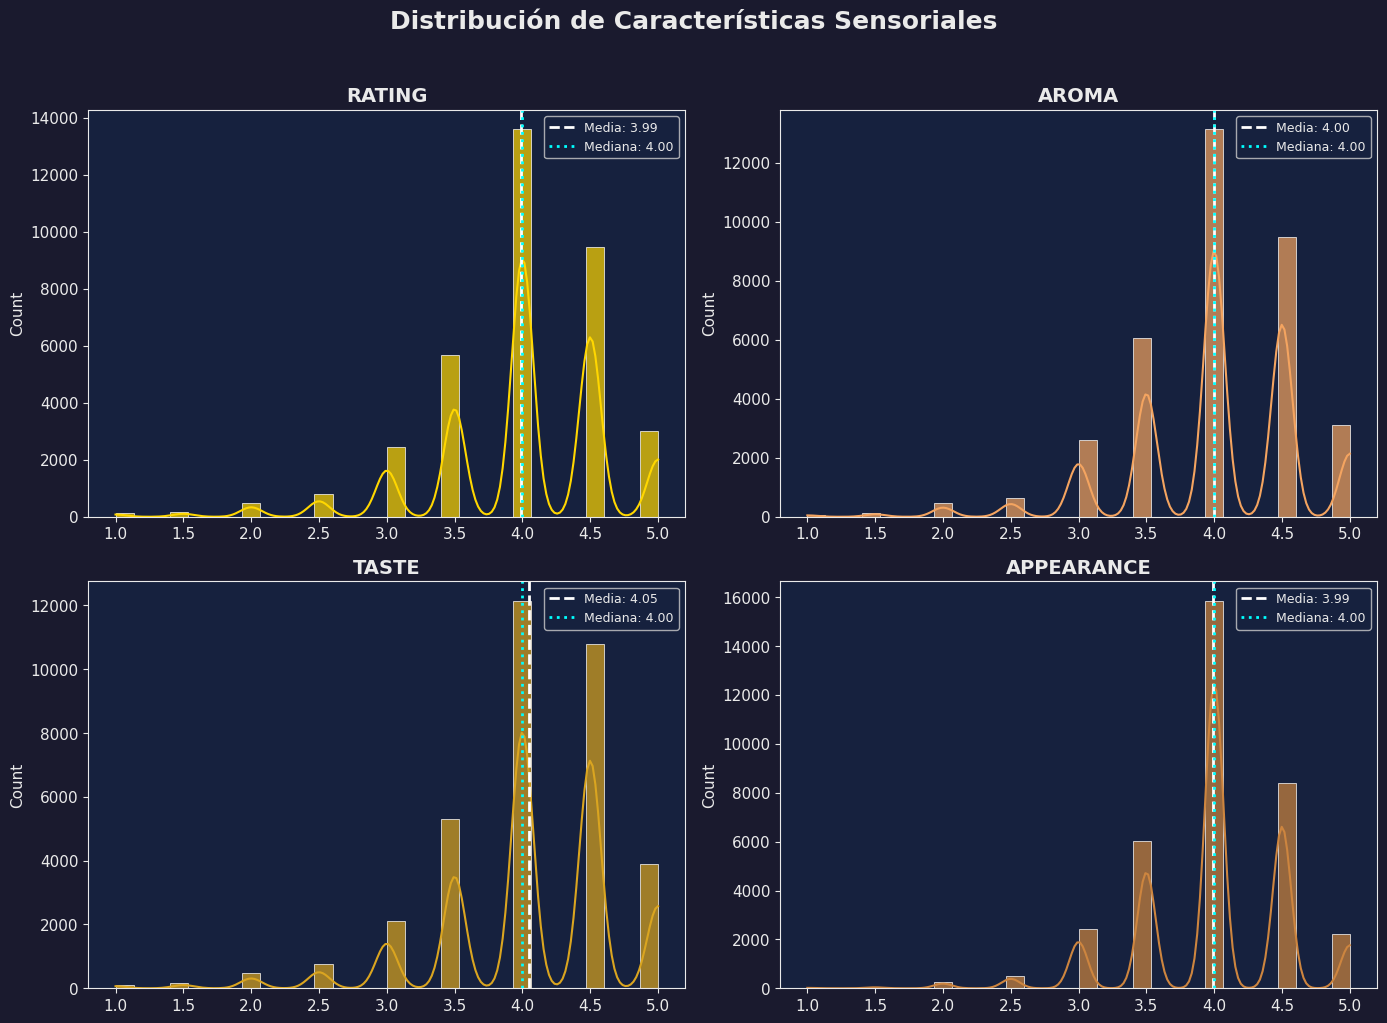

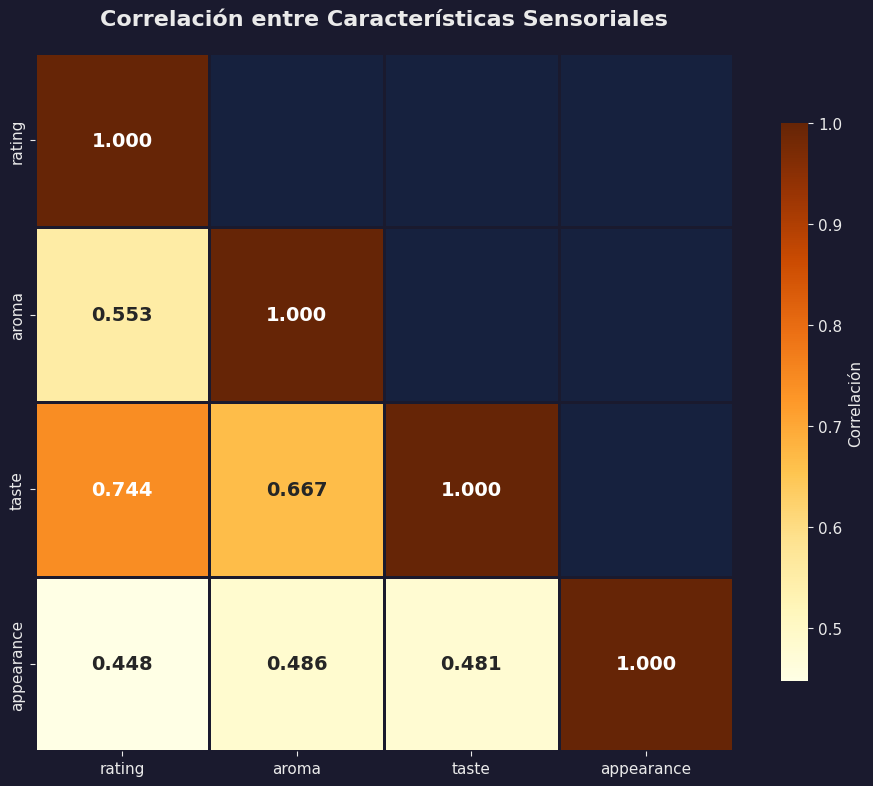

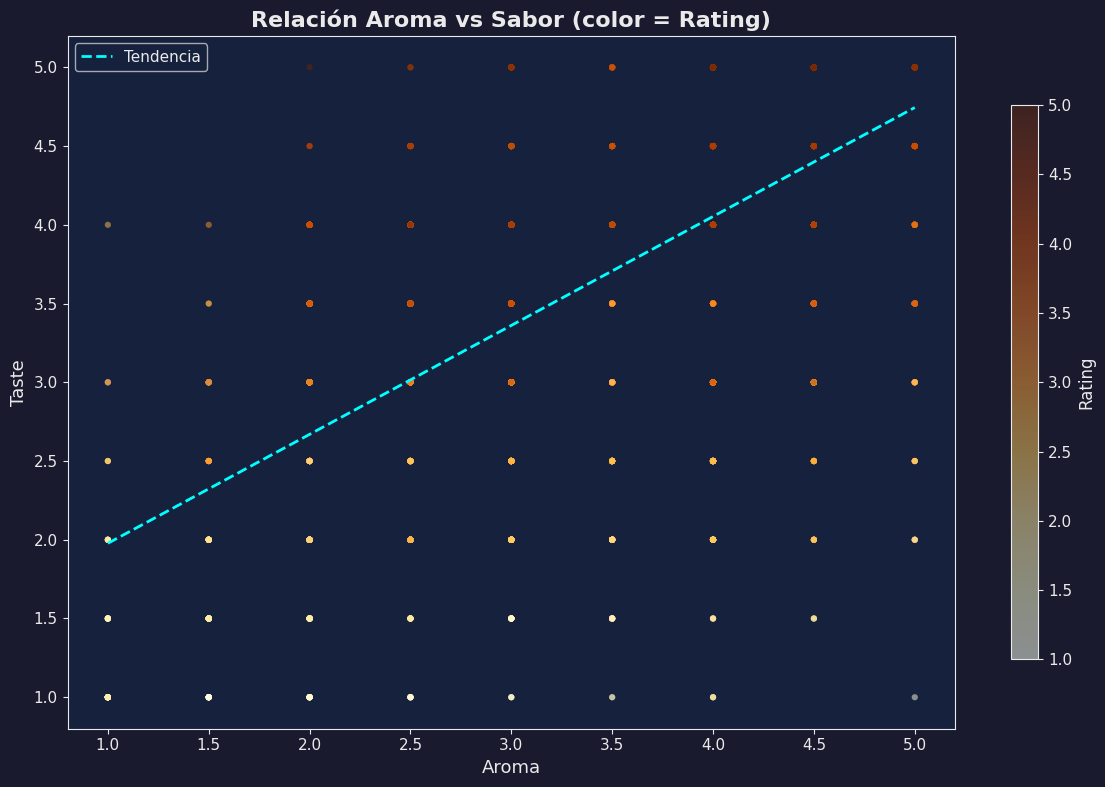

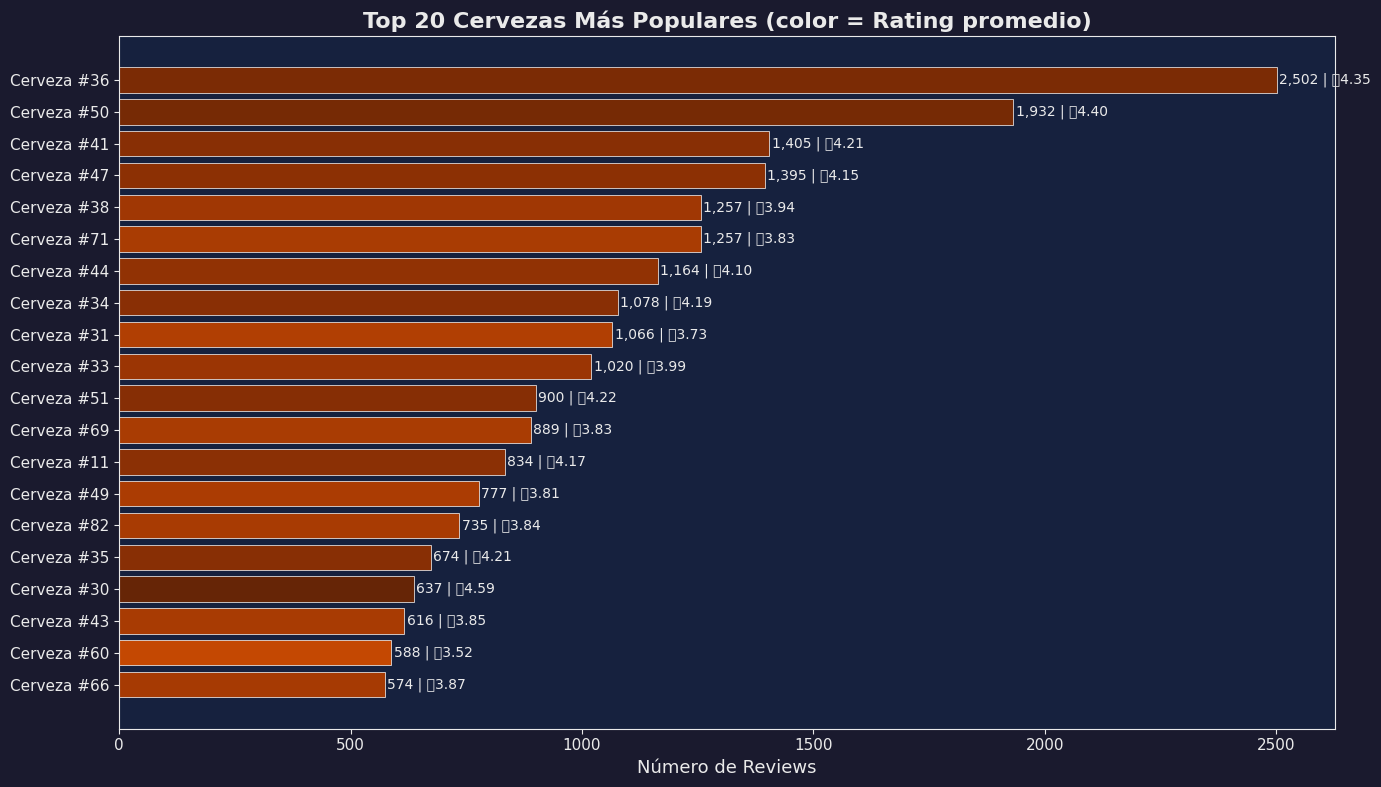

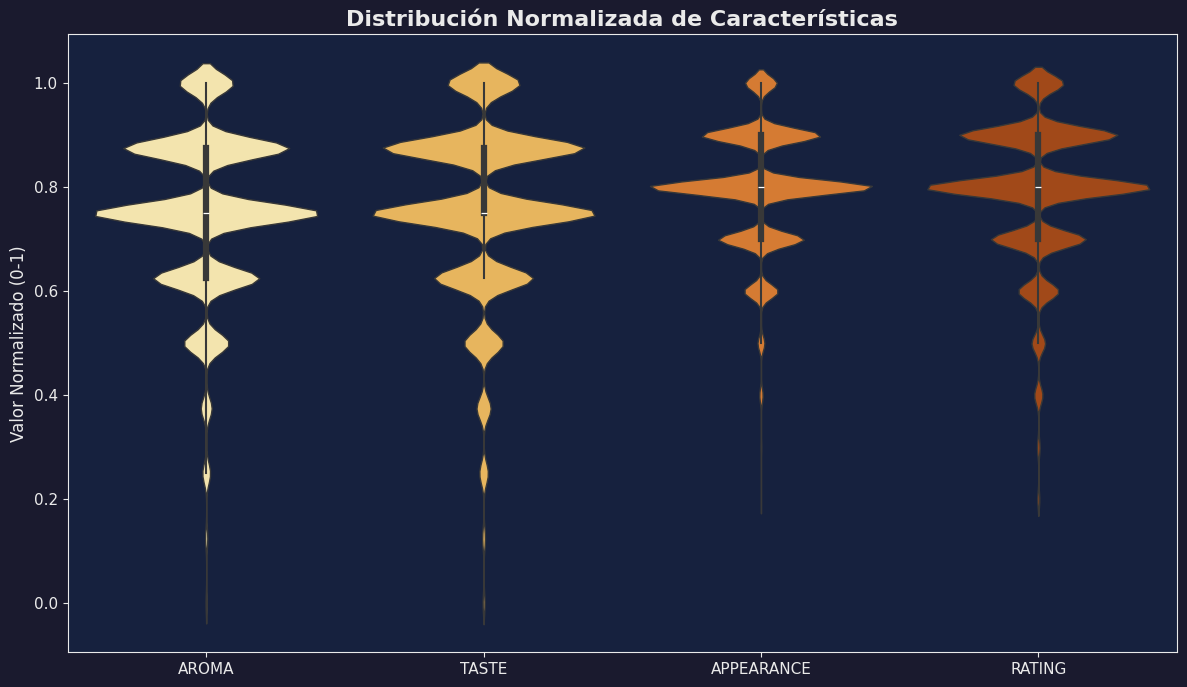

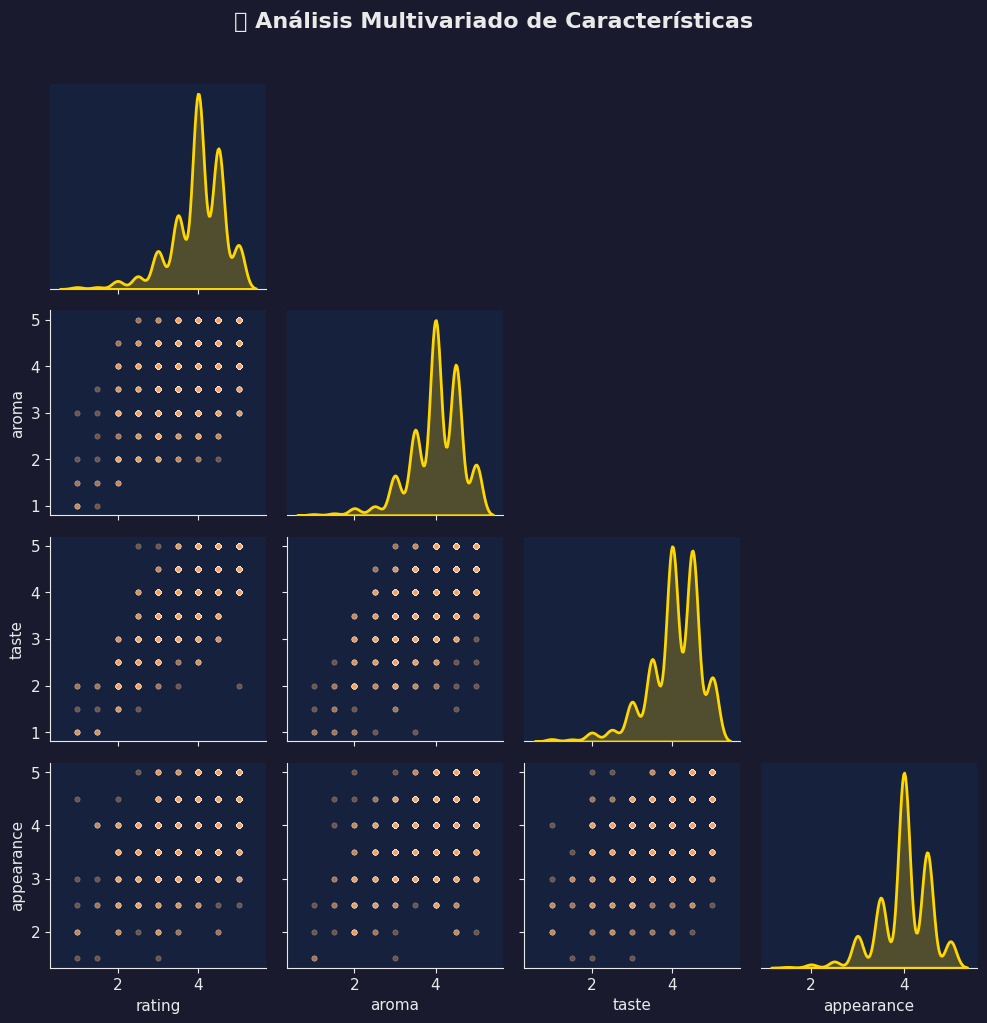

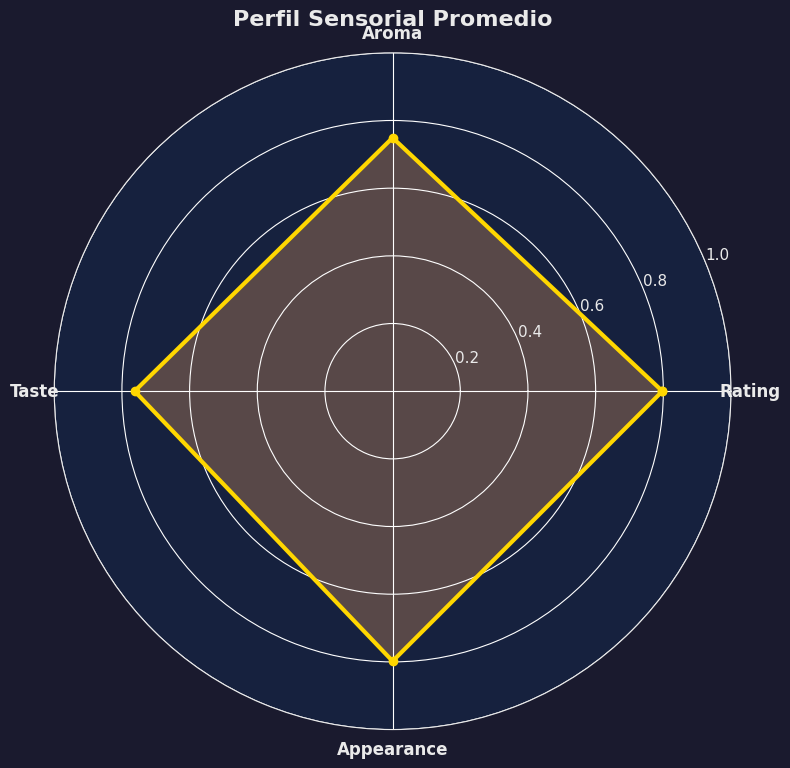

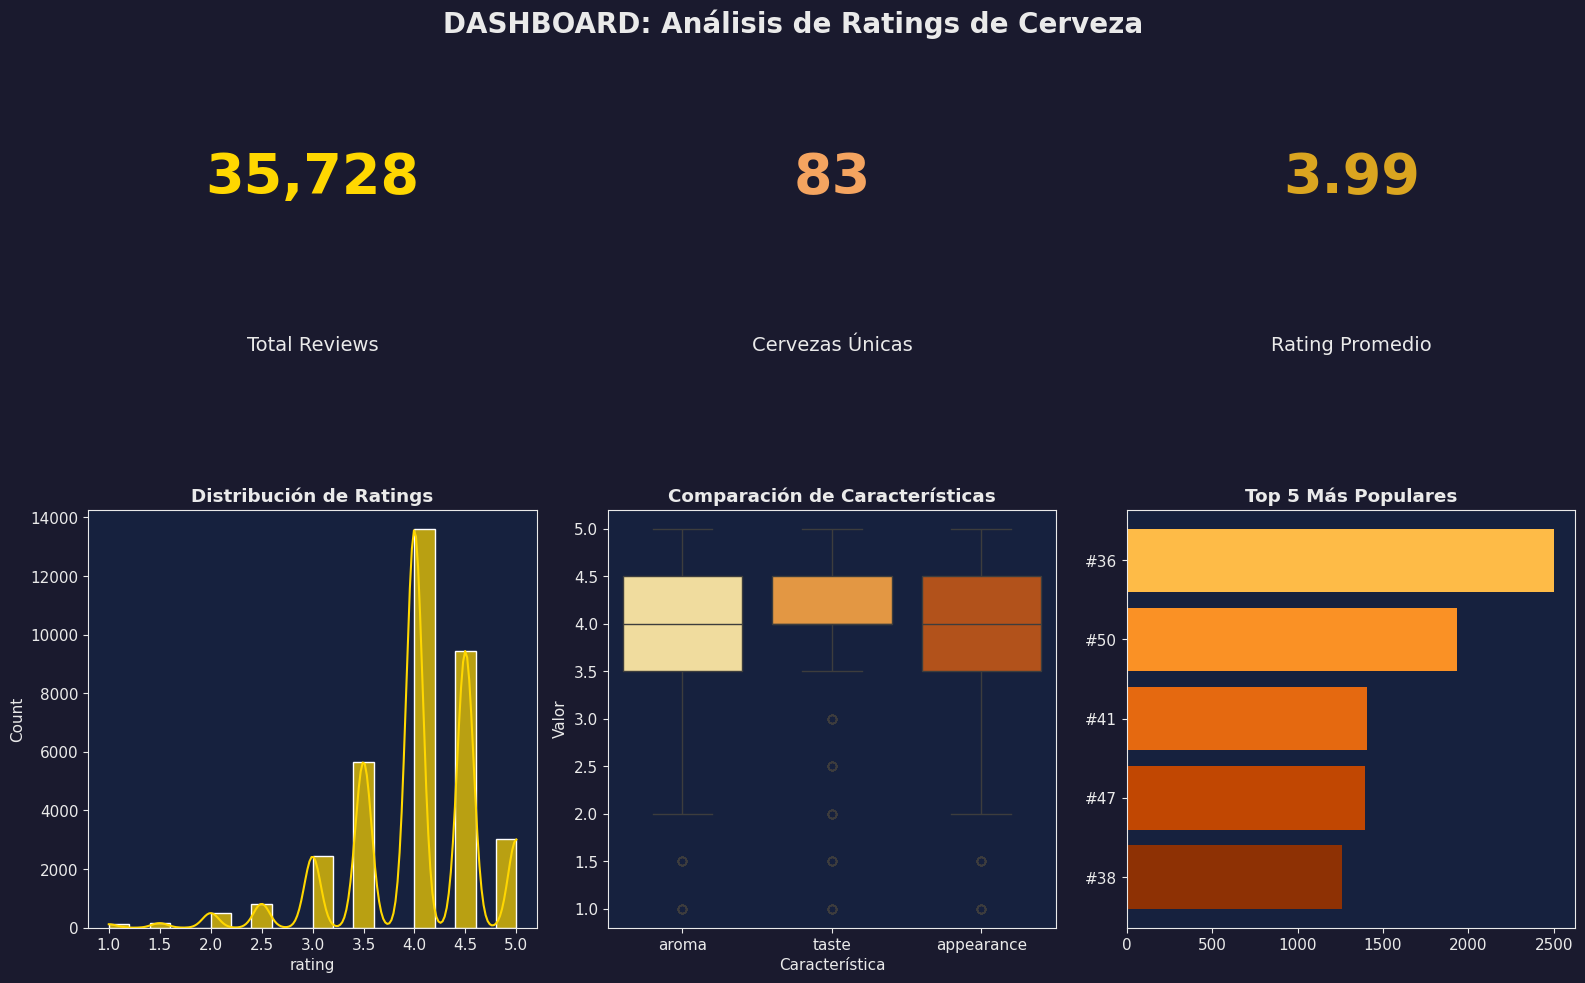

In [7]:
# Estilo oscuro
plt.style.use('dark_background')
sns.set_palette("viridis")

COLORS = {
    'primary': '#F4A460',      # Sandy brown (cerveza)
    'secondary': '#DAA520',    # Goldenrod
    'accent': '#CD853F',       # Peru
    'highlight': '#FFD700',    # Gold
    'background': '#1a1a2e',   # Dark blue
    'text': '#EAEAEA'
}

# Configuración de figuras
plt.rcParams['figure.facecolor'] = COLORS['background']
plt.rcParams['axes.facecolor'] = '#16213e'
plt.rcParams['axes.edgecolor'] = COLORS['text']
plt.rcParams['axes.labelcolor'] = COLORS['text']
plt.rcParams['xtick.color'] = COLORS['text']
plt.rcParams['ytick.color'] = COLORS['text']
plt.rcParams['text.color'] = COLORS['text']
plt.rcParams['font.size'] = 11

# ============================================================================
# 1. DISTRIBUCIÓN DE CARACTERÍSTICAS SENSORIALES
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribución de Características Sensoriales', fontsize=18, fontweight='bold', y=1.02)

features = ['rating', 'aroma', 'taste', 'appearance']
colors = ['#FFD700', '#F4A460', '#DAA520', '#CD853F']

for ax, feat, color in zip(axes.flatten(), features, colors):
    sns.histplot(data=df_filtered, x=feat, bins=30, kde=True, ax=ax,
                 color=color, edgecolor='white', alpha=0.7, linewidth=0.5)
    ax.axvline(df_filtered[feat].mean(), color='white', linestyle='--', linewidth=2, label=f'Media: {df_filtered[feat].mean():.2f}')
    ax.axvline(df_filtered[feat].median(), color='#00FFFF', linestyle=':', linewidth=2, label=f'Mediana: {df_filtered[feat].median():.2f}')
    ax.set_title(f'{feat.upper()}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. MATRIZ DE CORRELACIONES (HEATMAP ELEGANTE)
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 8))

corr_cols = ['rating', 'aroma', 'taste', 'appearance']
corr_matrix = df_filtered[corr_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='YlOrBr',
            square=True, linewidths=2, linecolor=COLORS['background'],
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8, 'label': 'Correlación'}, ax=ax)

ax.set_title('Correlación entre Características Sensoriales', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. SCATTER PLOT: AROMA VS TASTE (COLORED BY RATING)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df_filtered['aroma'], df_filtered['taste'],
                     c=df_filtered['rating'], cmap='YlOrBr',
                     alpha=0.5, s=20, edgecolors='none')

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Rating', fontsize=12)

ax.set_xlabel('Aroma', fontsize=13)
ax.set_ylabel('Taste', fontsize=13)
ax.set_title('Relación Aroma vs Sabor (color = Rating)', fontsize=16, fontweight='bold')

# Línea de regresión
z = np.polyfit(df_filtered['aroma'], df_filtered['taste'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_filtered['aroma'].min(), df_filtered['aroma'].max(), 100)
ax.plot(x_line, p(x_line), color='#00FFFF', linewidth=2, linestyle='--', label=f'Tendencia')
ax.legend()

plt.tight_layout()
plt.show()

# ============================================================================
# 4. TOP 20 CERVEZAS MÁS POPULARES
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 8))

top_items = df_filtered.groupby('action').agg({
    'rating': ['count', 'mean']
}).reset_index()
top_items.columns = ['action', 'count', 'avg_rating']
top_items = top_items.nlargest(20, 'count')

bars = ax.barh(range(len(top_items)), top_items['count'],
               color=plt.cm.YlOrBr(top_items['avg_rating'] / top_items['avg_rating'].max()),
               edgecolor='white', linewidth=0.5)

ax.set_yticks(range(len(top_items)))
ax.set_yticklabels([f"Cerveza #{int(x)}" for x in top_items['action']])
ax.set_xlabel('Número de Reviews', fontsize=13)
ax.set_title('Top 20 Cervezas Más Populares (color = Rating promedio)', fontsize=16, fontweight='bold')

# Añadir valores
for i, (count, rating) in enumerate(zip(top_items['count'], top_items['avg_rating'])):
    ax.text(count + 5, i, f'{count:,} | ⭐{rating:.2f}', va='center', fontsize=10)

ax.invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================================
# 5. VIOLIN PLOT: DISTRIBUCIÓN POR CARACTERÍSTICA
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Preparar datos en formato long
df_melt = df_filtered[['aroma_scaled', 'taste_scaled', 'appearance_scaled', 'rating_scaled']].melt(var_name='Feature', value_name='Value')
df_melt['Feature'] = df_melt['Feature'].str.replace('_scaled', '').str.upper()

sns.violinplot(data=df_melt, x='Feature', y='Value', palette='YlOrBr',
               inner='box', linewidth=1, ax=ax)

ax.set_title('Distribución Normalizada de Características', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Valor Normalizado (0-1)', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. PAIRPLOT CON KDE (RELACIONES MULTIVARIADAS)
# ============================================================================
sample_df = df_filtered[['rating', 'aroma', 'taste', 'appearance']].sample(n=min(2000, len(df_filtered)), random_state=42)

g = sns.pairplot(sample_df, diag_kind='kde', corner=True,
                 plot_kws={'alpha': 0.4, 's': 15, 'color': COLORS['primary']},
                 diag_kws={'color': COLORS['highlight'], 'linewidth': 2})

g.fig.suptitle('📊 Análisis Multivariado de Características', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# 7. RESUMEN ESTADÍSTICO VISUAL (RADAR CHART)
# ============================================================================
from math import pi

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

categories = ['Rating', 'Aroma', 'Taste', 'Appearance']
stats = df_filtered[['rating_scaled', 'aroma_scaled', 'taste_scaled', 'appearance_scaled']].mean().values

# Cerrar el polígono
stats = np.concatenate((stats, [stats[0]]))
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

ax.plot(angles, stats, 'o-', linewidth=3, color=COLORS['highlight'], label='Media')
ax.fill(angles, stats, alpha=0.3, color=COLORS['primary'])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Perfil Sensorial Promedio', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ============================================================================
# 8. DASHBOARD RESUMEN
# ============================================================================
fig = plt.figure(figsize=(16, 10))
fig.suptitle('DASHBOARD: Análisis de Ratings de Cerveza', fontsize=20, fontweight='bold', y=0.98)

# Métricas clave
ax1 = fig.add_subplot(2, 3, 1)
ax1.text(0.5, 0.7, f"{len(df_filtered):,}", fontsize=40, ha='center', va='center', fontweight='bold', color=COLORS['highlight'])
ax1.text(0.5, 0.3, "Total Reviews", fontsize=14, ha='center', va='center')
ax1.axis('off')

ax2 = fig.add_subplot(2, 3, 2)
ax2.text(0.5, 0.7, f"{df_filtered['action'].nunique():,}", fontsize=40, ha='center', va='center', fontweight='bold', color=COLORS['primary'])
ax2.text(0.5, 0.3, "Cervezas Únicas", fontsize=14, ha='center', va='center')
ax2.axis('off')

ax3 = fig.add_subplot(2, 3, 3)
ax3.text(0.5, 0.7, f"{df_filtered['rating'].mean():.2f}", fontsize=40, ha='center', va='center', fontweight='bold', color=COLORS['secondary'])
ax3.text(0.5, 0.3, "Rating Promedio", fontsize=14, ha='center', va='center')
ax3.axis('off')

# Histograma
ax4 = fig.add_subplot(2, 3, 4)
sns.histplot(df_filtered['rating'], bins=20, kde=True, color=COLORS['highlight'], ax=ax4, alpha=0.7)
ax4.set_title('Distribución de Ratings', fontweight='bold')

# Boxplot comparativo
ax5 = fig.add_subplot(2, 3, 5)
df_box = df_filtered[['aroma', 'taste', 'appearance']].melt(var_name='Característica', value_name='Valor')
sns.boxplot(data=df_box, x='Característica', y='Valor', palette='YlOrBr', ax=ax5)
ax5.set_title('Comparación de Características', fontweight='bold')

# Top 5 cervezas
ax6 = fig.add_subplot(2, 3, 6)
top5 = top_items.head(5)
ax6.barh(range(5), top5['count'], color=plt.cm.YlOrBr(np.linspace(0.4, 0.9, 5)))
ax6.set_yticks(range(5))
ax6.set_yticklabels([f"#{int(x)}" for x in top5['action']])
ax6.invert_yaxis()
ax6.set_title('Top 5 Más Populares', fontweight='bold')

plt.tight_layout()
plt.show()

## partición train y test por fecha

In [8]:
# Convertir año, mes y dia a un objeto fecha
df_filtered['date'] = pd.to_datetime(df_filtered[['year', 'month', 'day']])

# ordenar por fecha
df_filtered = df_filtered.sort_values('date')

# split 10% test dejar las ultimas fechas para testear
split_point = int(len(df_filtered) * 0.9)

# split en train and test
df_train = df_filtered.iloc[:split_point]
df_test = df_filtered.iloc[split_point:]

## Determinamos features, acciones y recompenzas para el entrenamiento

In [9]:
feature_columns = ['aroma_scaled', 'taste_scaled', 'appearance_scaled', 'user_id_encoded']

features = df_train[feature_columns].to_numpy()
actions = np.array(df_train.action)
rewards = np.array([x for x in df_train.rating_scaled])


## Instanciamos el modelo Multiarmed-Bandits

Necesitamos:
- Acciones posibles (`arms`), en este caso catalogo de items unicos.
- Algoritmo de Reinforcement Learning o `learning policy` (ej. Epsilon Greedy)
- Política de vecindad (`neighborhood_policy`) para incluir información contextual de vecinos cercanos con caracteristicas similares para reducir espacio de busqueda.

La politica de vecindad o `neighborhood_policy` es necesaria porque:
- Se utiliza en escenarios que requieren la incorporación de información contextual porque se complejiza el problema.
- La idea subyacente es que contextos similares probablemente tendrán acciones óptimas similares.
- Este algoritmo no trata cada contexto como un problema completamente distinto. En cambio, aprovecha la información adquirida de contextos que son similares.
- Al incorporalo, el algoritmo de Reinforcement Learning puede tomar decisiones más informadas y mejoradas.

In [10]:
# actiones posibles (cervezas a escoger del catalogo)
possible_actions = list(range(1, df_train.action.nunique() +1 ))

greedy = MAB(arms=possible_actions,learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.7), neighborhood_policy=NeighborhoodPolicy.KNearest(10))

In [11]:
X = features
y = rewards
decisions = df_train.action

In [12]:
greedy.fit(decisions= decisions, rewards= y , contexts=X)

## Evaluación


In [13]:
feature_columns = ['aroma_scaled', 'taste_scaled', 'appearance_scaled', 'user_id_encoded']

X_test = df_test[feature_columns].to_numpy()

prediction = greedy.predict(X_test)

scores = greedy.predict_expectations(X_test)

df_test['predicted_action'] = prediction

df_test['score'] = [ y[x] for x,y in zip(df_test['predicted_action'],scores)]

df_result = df_test[['user_id', 'action', 'rating_scaled' ,'predicted_action', 'score']]

df_result

,user_id,action,rating_scaled,predicted_action,score
15671,1199,31,0.7,41,0.325930
15670,1199,31,0.9,21,0.353031
29225,1199,46,0.6,51,0.700000
15673,1199,31,0.8,70,0.572061
17114,1199,32,1.0,36,0.950000
...,...,...,...,...,...
429,1075,2,0.9,7,0.370607
21084,1199,36,1.0,56,0.201260
21085,1199,36,1.0,11,0.000000
42206,263,68,0.8,18,0.853037


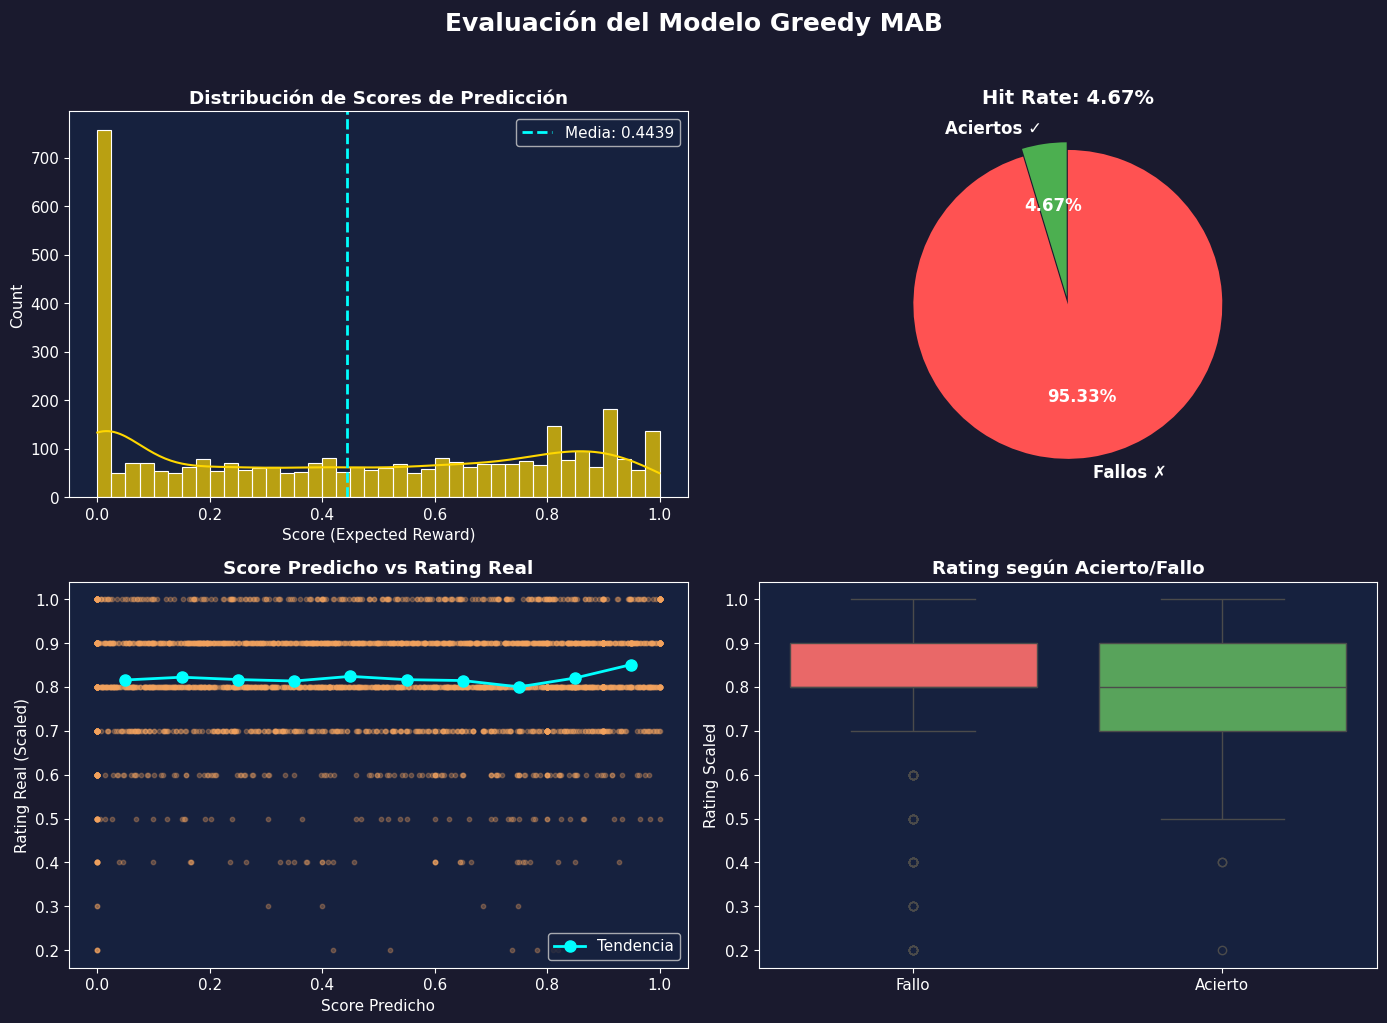


RESUMEN DE EVALUACIÓN
   Total predicciones:  3,573
   Hit Rate:            4.67%
   Score promedio:      0.4439
   Acciones únicas:     81
   Predicciones únicas: 83


In [14]:
#Visualización Gráfica de la Evaluación
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1a1a2e'
plt.rcParams['axes.facecolor'] = '#16213e'

# Métricas básicas
hit_rate = (df_result['action'] == df_result['predicted_action']).mean()
avg_score = df_result['score'].mean()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Evaluación del Modelo Greedy MAB', fontsize=18, fontweight='bold', y=1.02)

# ============================================================================
# 1. DISTRIBUCIÓN DE SCORES DE CONFIANZA
# ============================================================================
ax1 = axes[0, 0]
sns.histplot(df_result['score'], bins=40, kde=True, color='#FFD700', alpha=0.7, ax=ax1)
ax1.axvline(avg_score, color='#00FFFF', linestyle='--', linewidth=2, label=f'Media: {avg_score:.4f}')
ax1.set_title('Distribución de Scores de Predicción', fontweight='bold')
ax1.set_xlabel('Score (Expected Reward)')
ax1.legend()

# ============================================================================
# 2. HIT RATE - GAUGE VISUAL
# ============================================================================
ax2 = axes[0, 1]
ax2.pie([hit_rate, 1-hit_rate],
        labels=['Aciertos ✓', 'Fallos ✗'],
        colors=['#4CAF50', '#FF5252'],
        autopct='%1.2f%%',
        explode=(0.05, 0),
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title(f'Hit Rate: {hit_rate*100:.2f}%', fontweight='bold', fontsize=14)

# ============================================================================
# 3. SCORE VS RATING REAL
# ============================================================================
ax3 = axes[1, 0]
df_result['score_bin'] = pd.cut(df_result['score'], bins=10)
score_vs_rating = df_result.groupby('score_bin')['rating_scaled'].mean().reset_index()
score_vs_rating['score_mid'] = score_vs_rating['score_bin'].apply(lambda x: x.mid)

ax3.scatter(df_result['score'], df_result['rating_scaled'], alpha=0.3, s=10, c='#F4A460')
ax3.plot(score_vs_rating['score_mid'], score_vs_rating['rating_scaled'],
         'o-', color='#00FFFF', linewidth=2, markersize=8, label='Tendencia')
ax3.set_xlabel('Score Predicho')
ax3.set_ylabel('Rating Real (Scaled)')
ax3.set_title('Score Predicho vs Rating Real', fontweight='bold')
ax3.legend()

# ============================================================================
# 4. COMPARACIÓN: ACIERTOS VS FALLOS POR RATING (CORREGIDO)
# ============================================================================
ax4 = axes[1, 1]

df_result['hit'] = (df_result['action'] == df_result['predicted_action']).map({True: 'Acierto', False: 'Fallo'})

sns.boxplot(data=df_result, x='hit', y='rating_scaled',
            palette={'Acierto': '#4CAF50', 'Fallo': '#FF5252'},
            order=['Fallo', 'Acierto'], ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Rating Scaled')
ax4.set_title('Rating según Acierto/Fallo', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# RESUMEN TEXTUAL
# ============================================================================
print("\n" + "="*60)
print("RESUMEN DE EVALUACIÓN")
print("="*60)
print(f"   Total predicciones:  {len(df_result):,}")
print(f"   Hit Rate:            {hit_rate*100:.2f}%")
print(f"   Score promedio:      {avg_score:.4f}")
print(f"   Acciones únicas:     {df_result['action'].nunique()}")
print(f"   Predicciones únicas: {df_result['predicted_action'].nunique()}")
print("="*60)

# Declaración de Funciones

In [15]:
def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    return np.sum(r / np.log2(np.arange(2, r.size + 2)))

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

def recall_at_k(r, k, n_rel):
    r = np.asarray(r)[:k] != 0
    return np.sum(r) / n_rel

In [16]:
def calculate_metrics(df):
    unique_users = df['user_id'].unique()
    ndcg_5, ndcg_10, recall_5 , recall_10 = [], [], [], []

    for user in unique_users:
        user_df = df[df['user_id'] == user]

        # Ground Truth (Lo que el usuario realmente consumió)
        true_items = list(user_df['action'])

        # Predicciones del modelo ordenadas por score
        predicted_items = list(user_df.sort_values(by='score', ascending=False)['predicted_action'])

        # Verificamos si las PREDICCIONES existen.

        # Para NDCG (Importa el orden)
        binary_relevance = [1 if item in true_items else 0 for item in predicted_items]

        # NDCG
        ndcg_5.append(ndcg_at_k(binary_relevance, 5))
        ndcg_10.append(ndcg_at_k(binary_relevance, 10))

        # RECALL (Cobertura)
        # Cuántos items relevantes logramos encontrar en el top K

        # Top 5
        top_5_preds = set(predicted_items[:5])
        hits_5 = len(set(true_items) & top_5_preds)
        recall_5.append(hits_5 / len(true_items) if len(true_items) > 0 else 0)

        # Top 10
        top_10_preds = set(predicted_items[:10])
        hits_10 = len(set(true_items) & top_10_preds)
        recall_10.append(hits_10 / len(true_items) if len(true_items) > 0 else 0)

    return np.mean(ndcg_5) , np.mean(ndcg_10), np.mean(recall_5), np.mean(recall_10)

In [17]:
ndcg5, ndcg10, r5, r10 = calculate_metrics(df_result)

print("Average NDCG@5: ", ndcg5)
print("Average NDCG@10: ", ndcg10)
print("Average Recall@5: ", r5)
print("Average Recall@10: ", r10)

Average NDCG@5:  0.5013490030316263
Average NDCG@10:  0.5247273486938997
Average Recall@5:  0.09415443612685584
Average Recall@10:  0.1024446980945477


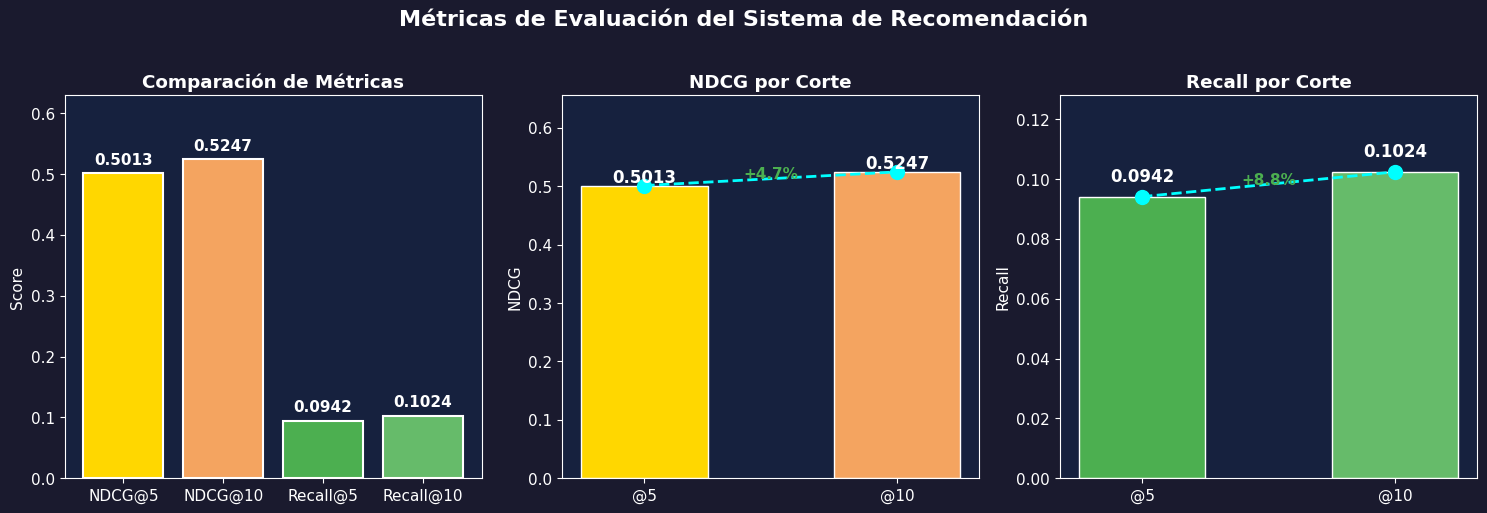


MÉTRICAS DE RANKING
   NDCG@5:    0.5013
   NDCG@10:   0.5247  (+4.7%)
   Recall@5:  0.0942
   Recall@10: 0.1024  (+8.8%)


In [18]:
# ============================================================================
# VISUALIZACIÓN DE MÉTRICAS DE RANKING
# ============================================================================
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1a1a2e'
plt.rcParams['axes.facecolor'] = '#16213e'

# Métricas
ndcg5, ndcg10, r5, r10 = calculate_metrics(df_result)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Métricas de Evaluación del Sistema de Recomendación', fontsize=16, fontweight='bold', y=1.02)

# ============================================================================
# 1. BARRAS COMPARATIVAS
# ============================================================================
ax1 = axes[0]
metrics = ['NDCG@5', 'NDCG@10', 'Recall@5', 'Recall@10']
values = [ndcg5, ndcg10, r5, r10]
colors = ['#FFD700', '#F4A460', '#4CAF50', '#66BB6A']

bars = ax1.bar(metrics, values, color=colors, edgecolor='white', linewidth=1.5)

# Añadir valores encima de las barras
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylim(0, max(values) * 1.2)
ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas', fontweight='bold')

# ============================================================================
# 2. NDCG: @5 vs @10
# ============================================================================
ax2 = axes[1]
ndcg_vals = [ndcg5, ndcg10]
x_pos = [0, 1]

ax2.bar(x_pos, ndcg_vals, color=['#FFD700', '#F4A460'], edgecolor='white', width=0.5)
ax2.plot(x_pos, ndcg_vals, 'o--', color='#00FFFF', linewidth=2, markersize=10)

for i, val in enumerate(ndcg_vals):
    ax2.text(i, val + 0.005, f'{val:.4f}', ha='center', fontsize=12, fontweight='bold')

ax2.set_xticks(x_pos)
ax2.set_xticklabels(['@5', '@10'])
ax2.set_ylabel('NDCG')
ax2.set_title('NDCG por Corte', fontweight='bold')
ax2.set_ylim(0, max(ndcg_vals) * 1.25)

# Flecha indicando cambio
delta_ndcg = ((ndcg10 - ndcg5) / ndcg5) * 100 if ndcg5 > 0 else 0
color_delta = '#4CAF50' if delta_ndcg >= 0 else '#FF5252'
ax2.annotate(f'{delta_ndcg:+.1f}%', xy=(0.5, (ndcg5 + ndcg10)/2), fontsize=11,
             ha='center', color=color_delta, fontweight='bold')

# ============================================================================
# 3. RECALL: @5 vs @10
# ============================================================================
ax3 = axes[2]
recall_vals = [r5, r10]

ax3.bar(x_pos, recall_vals, color=['#4CAF50', '#66BB6A'], edgecolor='white', width=0.5)
ax3.plot(x_pos, recall_vals, 'o--', color='#00FFFF', linewidth=2, markersize=10)

for i, val in enumerate(recall_vals):
    ax3.text(i, val + 0.005, f'{val:.4f}', ha='center', fontsize=12, fontweight='bold')

ax3.set_xticks(x_pos)
ax3.set_xticklabels(['@5', '@10'])
ax3.set_ylabel('Recall')
ax3.set_title('Recall por Corte', fontweight='bold')
ax3.set_ylim(0, max(recall_vals) * 1.25)

# Flecha indicando cambio
delta_recall = ((r10 - r5) / r5) * 100 if r5 > 0 else 0
color_delta = '#4CAF50' if delta_recall >= 0 else '#FF5252'
ax3.annotate(f'{delta_recall:+.1f}%', xy=(0.5, (r5 + r10)/2), fontsize=11,
             ha='center', color=color_delta, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# RESUMEN
# ============================================================================
print("\n" + "="*50)
print("MÉTRICAS DE RANKING")
print("="*50)
print(f"   NDCG@5:    {ndcg5:.4f}")
print(f"   NDCG@10:   {ndcg10:.4f}  ({delta_ndcg:+.1f}%)")
print(f"   Recall@5:  {r5:.4f}")
print(f"   Recall@10: {r10:.4f}  ({delta_recall:+.1f}%)")
print("="*50)

# Actividad
Con el mismo conjunto de datos probar:
1. `LinUCB`   
2. `UCB1`

Reportar los resultados y comentar si mejoran respecto a `EpsilonGreedy` mostrado en clases.

La elección de metaparámetros y la política de vecindad (`neighborhood_policy`) es de libre elección.

Puntaje:
- Código (3 ptos)
- Comentarios y discusión en una celda de texto (3 ptos)

Documentación:
https://fidelity.github.io/mabwiser/examples.html


In [19]:
# =============================================================================
# IMPLEMENTACIÓN 1: LinUCB
# =============================================================================
# Parámetros: alpha=2.0, sin neighborhood_policy
# Justificación: Sin clustering para evitar colapso observado con KNearest
# =============================================================================

# Montar Drive si no está montado
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

print("="*80)
print("ALGORITMO 1: LinUCB (Linear Upper Confidence Bound)")
print("="*80)

# Configuración
SAVE_DIR = '/content/drive/MyDrive/MAB_Results'
os.makedirs(SAVE_DIR, exist_ok=True)
LINUCB_FILE = os.path.join(SAVE_DIR, 'linucb_final.pkl')

# Parámetros
ALPHA_LINUCB = 2.0

# Verificar si ya existe resultado guardado
if os.path.exists(LINUCB_FILE):
    print("\n⚡ Cargando resultados desde Google Drive...")
    with open(LINUCB_FILE, 'rb') as f:
        saved = pickle.load(f)
        df_result_linucb = saved['df_result']
        training_time = saved['training_time']
        prediction_time = saved['prediction_time']

    print(f"✓ Resultados cargados exitosamente")
    print(f"✓ Tiempo de entrenamiento: {training_time:.2f}s")
    print(f"✓ Tiempo de predicción: {prediction_time:.2f}s")
    print(f"✓ Total de predicciones: {len(df_result_linucb)}")

else:
    print("\n🔧 Entrenando LinUCB desde cero...")
    print(f"Parámetros: alpha={ALPHA_LINUCB}, sin neighborhood_policy")

    # Usar misma estructura que EpsilonGreedy
    possible_actions = list(range(1, df_train.action.nunique() + 1))
    feature_columns = ['aroma_scaled', 'taste_scaled', 'appearance_scaled', 'user_id_encoded']

    features = df_train[feature_columns].to_numpy()
    actions = np.array(df_train.action)
    rewards = np.array([x for x in df_train.rating_scaled])

    # Crear modelo LinUCB
    mab_linucb = MAB(
        arms=possible_actions,
        learning_policy=LearningPolicy.LinUCB(alpha=ALPHA_LINUCB)
        # SIN neighborhood_policy para evitar colapso
    )

    # Entrenar
    print("Entrenando modelo...")
    start_train = time()
    mab_linucb.fit(decisions=actions, rewards=rewards, contexts=features)
    training_time = time() - start_train
    print(f"✓ Entrenamiento completado en {training_time:.2f} segundos")

    # Predecir en test completo
    X_test = df_test[feature_columns].to_numpy()

    print(f"Prediciendo en {len(df_test)} registros de test...")
    start_pred = time()
    prediction_linucb = mab_linucb.predict(X_test)
    scores_linucb = mab_linucb.predict_expectations(X_test)
    prediction_time = time() - start_pred
    print(f"✓ Predicción completada en {prediction_time:.2f} segundos")

    # Crear DataFrame de resultados
    df_test_linucb = df_test.copy()
    df_test_linucb['predicted_action'] = prediction_linucb
    df_test_linucb['score'] = [y[x] for x, y in zip(df_test_linucb['predicted_action'], scores_linucb)]

    df_result_linucb = df_test_linucb[['user_id', 'action', 'rating_scaled', 'predicted_action', 'score']]

    # Guardar en Drive
    save_data = {
        'df_result': df_result_linucb,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'alpha': ALPHA_LINUCB
    }

    with open(LINUCB_FILE, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"✓ Resultados guardados en Drive: {LINUCB_FILE}")

# Diagnóstico
print(f"\n📊 Diagnóstico LinUCB:")
print(f"   Items únicos predichos: {df_result_linucb['predicted_action'].nunique()} de 83")
print(f"   Top 5 items más predichos:")
for item, count in df_result_linucb['predicted_action'].value_counts().head(5).items():
    print(f"      Item {item}: {count} veces ({count/len(df_result_linucb)*100:.1f}%)")
print("="*80)

Mounted at /content/drive
ALGORITMO 1: LinUCB (Linear Upper Confidence Bound)

🔧 Entrenando LinUCB desde cero...
Parámetros: alpha=2.0, sin neighborhood_policy
Entrenando modelo...
✓ Entrenamiento completado en 0.03 segundos
Prediciendo en 3573 registros de test...
✓ Predicción completada en 0.06 segundos
✓ Resultados guardados en Drive: /content/drive/MyDrive/MAB_Results/linucb_final.pkl

📊 Diagnóstico LinUCB:
   Items únicos predichos: 12 de 83
   Top 5 items más predichos:
      Item 3: 2358 veces (66.0%)
      Item 24: 435 veces (12.2%)
      Item 76: 363 veces (10.2%)
      Item 25: 271 veces (7.6%)
      Item 78: 88 veces (2.5%)


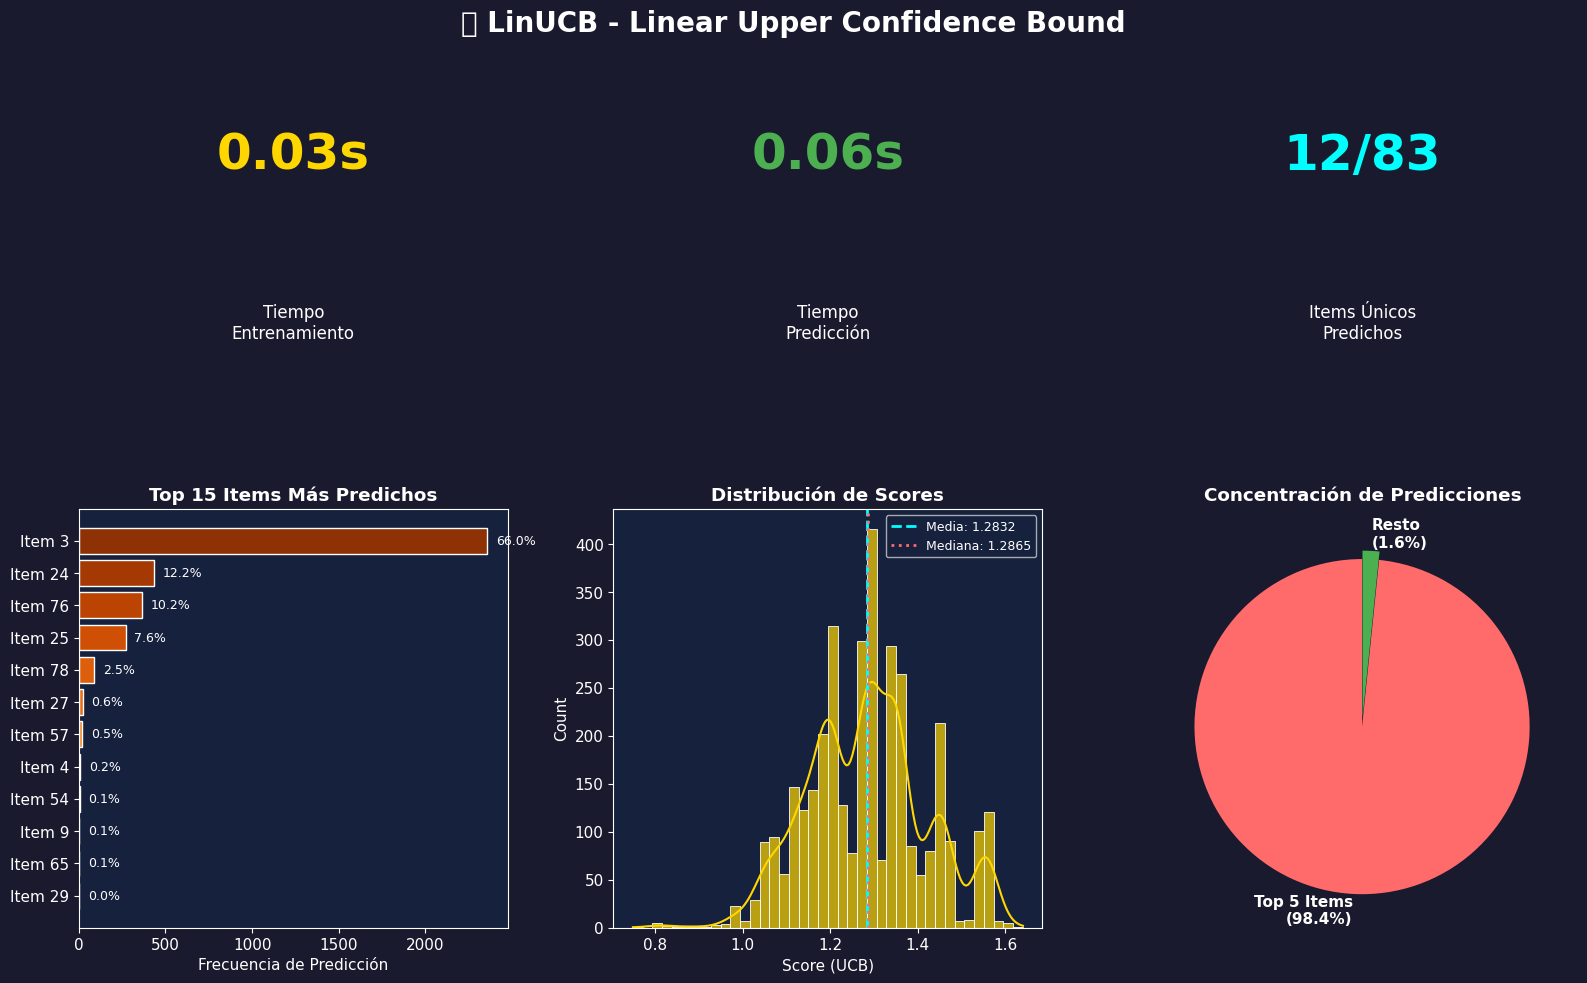


RESUMEN LinUCB
   Alpha:               2.0
   Entrenamiento:       0.03s
   Predicción:          0.06s
   Total predicciones:  3,573
   Items únicos:        12/83 (14.5%)
   Score promedio:      1.2832
   Concentración Top 5: 98.4%

MÉTRICAS DE RANKING:
   NDCG@5:    0.0483
   NDCG@10:   0.0477
   Recall@5:  0.0013
   Recall@10: 0.0013


In [20]:
# ============================================================================
# VISUALIZACIÓN DE RESULTADOS - LinUCB
# ============================================================================
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1a1a2e'
plt.rcParams['axes.facecolor'] = '#16213e'

fig = plt.figure(figsize=(16, 10))
fig.suptitle('🎰 LinUCB - Linear Upper Confidence Bound', fontsize=20, fontweight='bold', y=0.98)

# ============================================================================
# 1. MÉTRICAS CLAVE (Cards)
# ============================================================================
ax1 = fig.add_subplot(2, 3, 1)
ax1.text(0.5, 0.75, f"{training_time:.2f}s", fontsize=36, ha='center', va='center',
         fontweight='bold', color='#FFD700')
ax1.text(0.5, 0.35, "Tiempo\nEntrenamiento", fontsize=12, ha='center', va='center')
ax1.axis('off')

ax2 = fig.add_subplot(2, 3, 2)
ax2.text(0.5, 0.75, f"{prediction_time:.2f}s", fontsize=36, ha='center', va='center',
         fontweight='bold', color='#4CAF50')
ax2.text(0.5, 0.35, "Tiempo\nPredicción", fontsize=12, ha='center', va='center')
ax2.axis('off')

ax3 = fig.add_subplot(2, 3, 3)
items_predichos = df_result_linucb['predicted_action'].nunique()
ax3.text(0.5, 0.75, f"{items_predichos}/83", fontsize=36, ha='center', va='center',
         fontweight='bold', color='#00FFFF')
ax3.text(0.5, 0.35, "Items Únicos\nPredichos", fontsize=12, ha='center', va='center')
ax3.axis('off')

# ============================================================================
# 2. DISTRIBUCIÓN DE PREDICCIONES (Top 15)
# ============================================================================
ax4 = fig.add_subplot(2, 3, 4)
top_predictions = df_result_linucb['predicted_action'].value_counts().head(15)

colors = plt.cm.YlOrBr(np.linspace(0.3, 0.9, len(top_predictions)))[::-1]
bars = ax4.barh(range(len(top_predictions)), top_predictions.values, color=colors, edgecolor='white')

ax4.set_yticks(range(len(top_predictions)))
ax4.set_yticklabels([f"Item {int(x)}" for x in top_predictions.index])
ax4.invert_yaxis()
ax4.set_xlabel('Frecuencia de Predicción')
ax4.set_title('Top 15 Items Más Predichos', fontweight='bold')

# Porcentajes
for i, (val, idx) in enumerate(zip(top_predictions.values, top_predictions.index)):
    pct = val / len(df_result_linucb) * 100
    ax4.text(val + 50, i, f'{pct:.1f}%', va='center', fontsize=9)

# ============================================================================
# 3. DISTRIBUCIÓN DE SCORES
# ============================================================================
ax5 = fig.add_subplot(2, 3, 5)
sns.histplot(df_result_linucb['score'], bins=40, kde=True, color='#FFD700', alpha=0.7, ax=ax5)
ax5.axvline(df_result_linucb['score'].mean(), color='#00FFFF', linestyle='--',
            linewidth=2, label=f"Media: {df_result_linucb['score'].mean():.4f}")
ax5.axvline(df_result_linucb['score'].median(), color='#FF6B6B', linestyle=':',
            linewidth=2, label=f"Mediana: {df_result_linucb['score'].median():.4f}")
ax5.set_xlabel('Score (UCB)')
ax5.set_title('Distribución de Scores', fontweight='bold')
ax5.legend(fontsize=9)

# ============================================================================
# 4. COBERTURA DE ITEMS (PIE)
# ============================================================================
ax6 = fig.add_subplot(2, 3, 6)

# Concentración en top items
top5_pct = df_result_linucb['predicted_action'].value_counts().head(5).sum() / len(df_result_linucb) * 100
rest_pct = 100 - top5_pct

ax6.pie([top5_pct, rest_pct],
        labels=[f'Top 5 Items\n({top5_pct:.1f}%)', f'Resto\n({rest_pct:.1f}%)'],
        colors=['#FF6B6B', '#4CAF50'],
        explode=(0.05, 0),
        autopct='',
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'})
ax6.set_title('Concentración de Predicciones', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# RESUMEN TEXTUAL
# ============================================================================
print("\n" + "="*60)
print("RESUMEN LinUCB")
print("="*60)
print(f"   Alpha:               {ALPHA_LINUCB}")
print(f"   Entrenamiento:       {training_time:.2f}s")
print(f"   Predicción:          {prediction_time:.2f}s")
print(f"   Total predicciones:  {len(df_result_linucb):,}")
print(f"   Items únicos:        {items_predichos}/83 ({items_predichos/83*100:.1f}%)")
print(f"   Score promedio:      {df_result_linucb['score'].mean():.4f}")
print(f"   Concentración Top 5: {top5_pct:.1f}%")
print("="*60)

# ============================================================================
# CALCULAR Y MOSTRAR MÉTRICAS DE RANKING
# ============================================================================
ndcg5_lin, ndcg10_lin, r5_lin, r10_lin = calculate_metrics(df_result_linucb)

print("\nMÉTRICAS DE RANKING:")
print(f"   NDCG@5:    {ndcg5_lin:.4f}")
print(f"   NDCG@10:   {ndcg10_lin:.4f}")
print(f"   Recall@5:  {r5_lin:.4f}")
print(f"   Recall@10: {r10_lin:.4f}")
print("="*60)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# =============================================================================
# IMPLEMENTACIÓN 2: UCB1
# =============================================================================
# Parámetros: alpha=1.0, k=10 (iguales a EpsilonGreedy para comparación justa)
# =============================================================================

print("="*80)
print("ALGORITMO 2: UCB1 (Upper Confidence Bound 1)")
print("="*80)

UCB1_FILE = os.path.join(SAVE_DIR, 'ucb1_final.pkl')

# Parámetros
ALPHA_UCB1 = 1.0
K_NEIGHBORS = 10

if os.path.exists(UCB1_FILE):
    print("\n⚡ Cargando resultados desde Google Drive...")
    with open(UCB1_FILE, 'rb') as f:
        saved = pickle.load(f)
        df_result_ucb1 = saved['df_result']
        training_time = saved['training_time']
        prediction_time = saved['prediction_time']

    print(f"✓ Resultados cargados exitosamente")
    print(f"✓ Tiempo de entrenamiento: {training_time:.2f}s")
    print(f"✓ Tiempo de predicción: {prediction_time:.2f}s")
    print(f"✓ Total de predicciones: {len(df_result_ucb1)}")

else:
    print("\n🔧 Entrenando UCB1 desde cero...")
    print(f"Parámetros: alpha={ALPHA_UCB1}, k={K_NEIGHBORS} vecinos")

    # Crear modelo UCB1
    mab_ucb1 = MAB(
        arms=possible_actions,
        learning_policy=LearningPolicy.UCB1(alpha=ALPHA_UCB1),
        neighborhood_policy=NeighborhoodPolicy.KNearest(K_NEIGHBORS)
    )

    # Entrenar
    print("Entrenando modelo...")
    start_train = time()
    mab_ucb1.fit(decisions=actions, rewards=rewards, contexts=features)
    training_time = time() - start_train
    print(f"✓ Entrenamiento completado en {training_time:.2f} segundos")

    # Predecir
    print(f"Prediciendo en {len(df_test)} registros de test...")
    start_pred = time()
    prediction_ucb1 = mab_ucb1.predict(X_test)
    scores_ucb1 = mab_ucb1.predict_expectations(X_test)
    prediction_time = time() - start_pred
    print(f"✓ Predicción completada en {prediction_time:.2f} segundos")

    # Crear DataFrame de resultados
    df_test_ucb1 = df_test.copy()
    df_test_ucb1['predicted_action'] = prediction_ucb1
    df_test_ucb1['score'] = [y[x] for x, y in zip(df_test_ucb1['predicted_action'], scores_ucb1)]

    df_result_ucb1 = df_test_ucb1[['user_id', 'action', 'rating_scaled', 'predicted_action', 'score']]

    # Guardar
    save_data = {
        'df_result': df_result_ucb1,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'alpha': ALPHA_UCB1,
        'k_neighbors': K_NEIGHBORS
    }

    with open(UCB1_FILE, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"✓ Resultados guardados en Drive: {UCB1_FILE}")

# Diagnóstico
print(f"\n📊 Diagnóstico UCB1:")
print(f"   Items únicos predichos: {df_result_ucb1['predicted_action'].nunique()} de 83")
print(f"   Top 5 items más predichos:")
for item, count in df_result_ucb1['predicted_action'].value_counts().head(5).items():
    print(f"      Item {item}: {count} veces ({count/len(df_result_ucb1)*100:.1f}%)")
print("="*80)

ALGORITMO 2: UCB1 (Upper Confidence Bound 1)

🔧 Entrenando UCB1 desde cero...
Parámetros: alpha=1.0, k=10 vecinos
Entrenando modelo...
✓ Entrenamiento completado en 0.00 segundos
Prediciendo en 3573 registros de test...
✓ Predicción completada en 15.17 segundos
✓ Resultados guardados en Drive: /content/drive/MyDrive/MAB_Results/ucb1_final.pkl

📊 Diagnóstico UCB1:
   Items únicos predichos: 82 de 83
   Top 5 items más predichos:
      Item 41: 437 veces (12.2%)
      Item 47: 412 veces (11.5%)
      Item 34: 264 veces (7.4%)
      Item 33: 240 veces (6.7%)
      Item 44: 183 veces (5.1%)


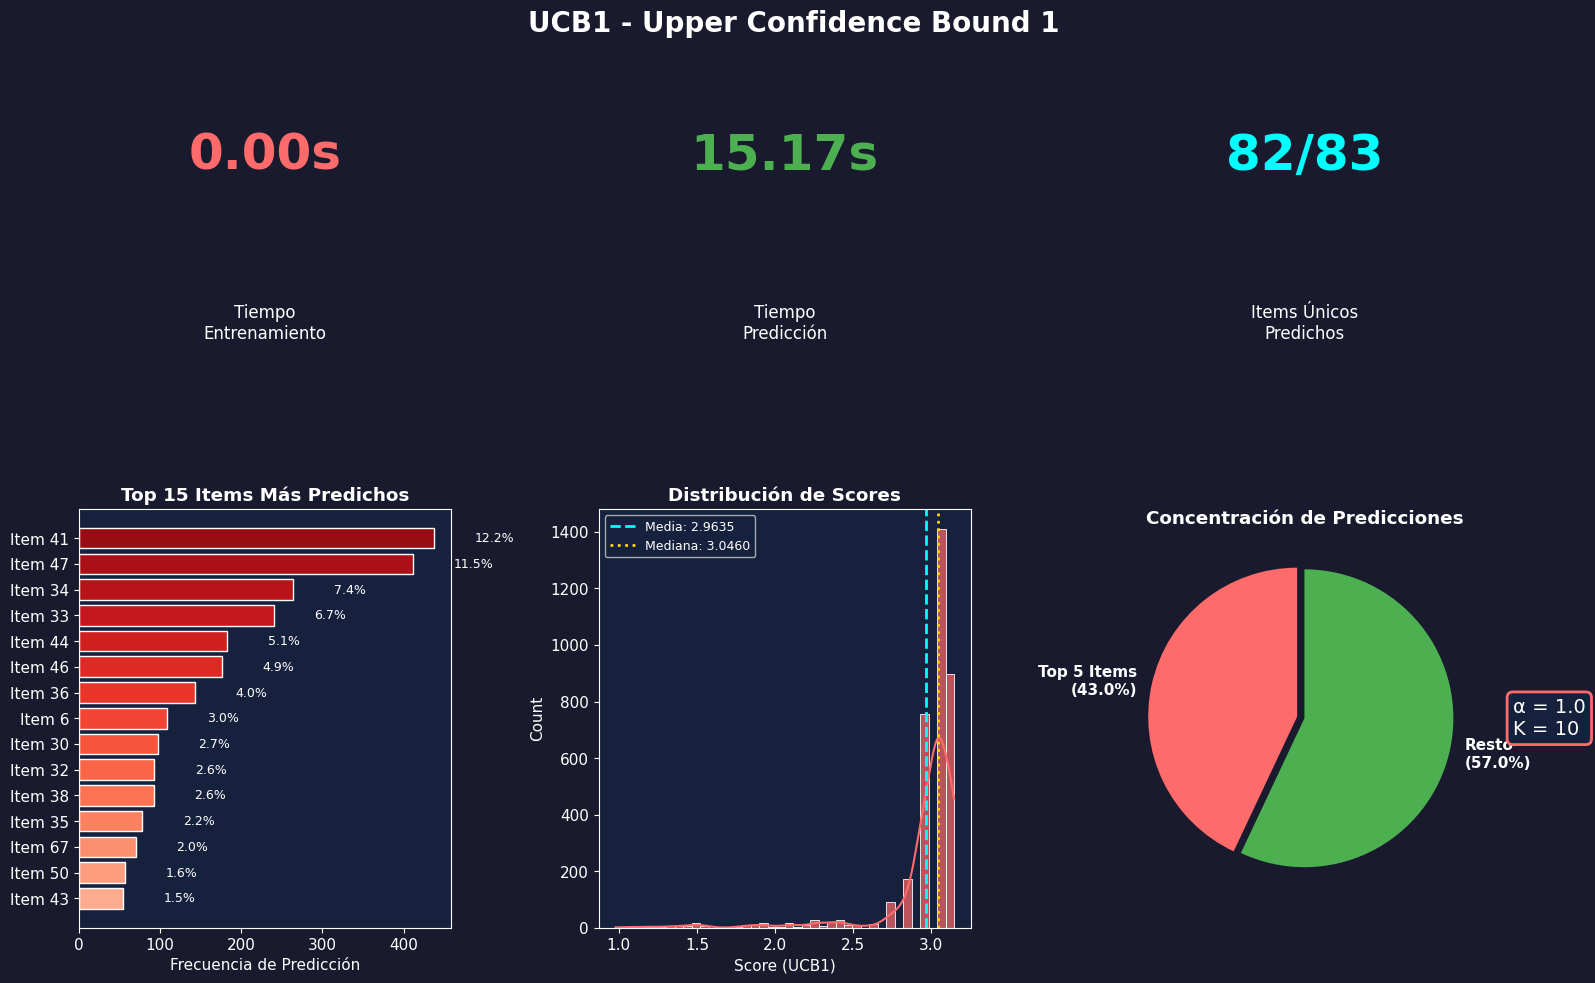


📊 RESUMEN UCB1
   Alpha:               1.0
   K Neighbors:         10
   Entrenamiento:       0.00s
   Predicción:          15.17s
   Total predicciones:  3,573
   Items únicos:        82/83 (98.8%)
   Score promedio:      2.9635
   Concentración Top 5: 43.0%

MÉTRICAS DE RANKING:
   NDCG@5:    0.5135
   NDCG@10:   0.5277
   Recall@5:  0.0503
   Recall@10: 0.0613


In [23]:
# ============================================================================
# VISUALIZACIÓN DE RESULTADOS - UCB1
# ============================================================================

plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1a1a2e'
plt.rcParams['axes.facecolor'] = '#16213e'

fig = plt.figure(figsize=(16, 10))
fig.suptitle('UCB1 - Upper Confidence Bound 1', fontsize=20, fontweight='bold', y=0.98)

# ============================================================================
# 1. MÉTRICAS CLAVE (Cards)
# ============================================================================
ax1 = fig.add_subplot(2, 3, 1)
ax1.text(0.5, 0.75, f"{training_time:.2f}s", fontsize=36, ha='center', va='center',
         fontweight='bold', color='#FF6B6B')
ax1.text(0.5, 0.35, "Tiempo\nEntrenamiento", fontsize=12, ha='center', va='center')
ax1.axis('off')

ax2 = fig.add_subplot(2, 3, 2)
ax2.text(0.5, 0.75, f"{prediction_time:.2f}s", fontsize=36, ha='center', va='center',
         fontweight='bold', color='#4CAF50')
ax2.text(0.5, 0.35, "Tiempo\nPredicción", fontsize=12, ha='center', va='center')
ax2.axis('off')

ax3 = fig.add_subplot(2, 3, 3)
items_predichos_ucb1 = df_result_ucb1['predicted_action'].nunique()
ax3.text(0.5, 0.75, f"{items_predichos_ucb1}/83", fontsize=36, ha='center', va='center',
         fontweight='bold', color='#00FFFF')
ax3.text(0.5, 0.35, "Items Únicos\nPredichos", fontsize=12, ha='center', va='center')
ax3.axis('off')

# ============================================================================
# 2. DISTRIBUCIÓN DE PREDICCIONES (Top 15)
# ============================================================================
ax4 = fig.add_subplot(2, 3, 4)
top_predictions_ucb1 = df_result_ucb1['predicted_action'].value_counts().head(15)

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(top_predictions_ucb1)))[::-1]
bars = ax4.barh(range(len(top_predictions_ucb1)), top_predictions_ucb1.values, color=colors, edgecolor='white')

ax4.set_yticks(range(len(top_predictions_ucb1)))
ax4.set_yticklabels([f"Item {int(x)}" for x in top_predictions_ucb1.index])
ax4.invert_yaxis()
ax4.set_xlabel('Frecuencia de Predicción')
ax4.set_title('Top 15 Items Más Predichos', fontweight='bold')

for i, (val, idx) in enumerate(zip(top_predictions_ucb1.values, top_predictions_ucb1.index)):
    pct = val / len(df_result_ucb1) * 100
    ax4.text(val + 50, i, f'{pct:.1f}%', va='center', fontsize=9)

# ============================================================================
# 3. DISTRIBUCIÓN DE SCORES
# ============================================================================
ax5 = fig.add_subplot(2, 3, 5)
sns.histplot(df_result_ucb1['score'], bins=40, kde=True, color='#FF6B6B', alpha=0.7, ax=ax5)
ax5.axvline(df_result_ucb1['score'].mean(), color='#00FFFF', linestyle='--',
            linewidth=2, label=f"Media: {df_result_ucb1['score'].mean():.4f}")
ax5.axvline(df_result_ucb1['score'].median(), color='#FFD700', linestyle=':',
            linewidth=2, label=f"Mediana: {df_result_ucb1['score'].median():.4f}")
ax5.set_xlabel('Score (UCB1)')
ax5.set_title('Distribución de Scores', fontweight='bold')
ax5.legend(fontsize=9)

# ============================================================================
# 4. PARÁMETROS Y COBERTURA
# ============================================================================
ax6 = fig.add_subplot(2, 3, 6)

# Concentración en top items
top5_pct_ucb1 = df_result_ucb1['predicted_action'].value_counts().head(5).sum() / len(df_result_ucb1) * 100
rest_pct_ucb1 = 100 - top5_pct_ucb1

wedges, texts = ax6.pie(
    [top5_pct_ucb1, rest_pct_ucb1],
    labels=[f'Top 5 Items\n({top5_pct_ucb1:.1f}%)', f'Resto\n({rest_pct_ucb1:.1f}%)'],
    colors=['#FF6B6B', '#4CAF50'],
    explode=(0.05, 0),
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
ax6.set_title('Concentración de Predicciones', fontweight='bold')

# Añadir parámetros como texto
param_text = f"α = {ALPHA_UCB1}\nK = {K_NEIGHBORS}"
ax6.text(1.4, 0, param_text, fontsize=14, ha='left', va='center',
         bbox=dict(boxstyle='round', facecolor='#16213e', edgecolor='#FF6B6B', linewidth=2))

plt.tight_layout()
plt.show()

# ============================================================================
# RESUMEN TEXTUAL
# ============================================================================
print("\n" + "="*60)
print("📊 RESUMEN UCB1")
print("="*60)
print(f"   Alpha:               {ALPHA_UCB1}")
print(f"   K Neighbors:         {K_NEIGHBORS}")
print(f"   Entrenamiento:       {training_time:.2f}s")
print(f"   Predicción:          {prediction_time:.2f}s")
print(f"   Total predicciones:  {len(df_result_ucb1):,}")
print(f"   Items únicos:        {items_predichos_ucb1}/83 ({items_predichos_ucb1/83*100:.1f}%)")
print(f"   Score promedio:      {df_result_ucb1['score'].mean():.4f}")
print(f"   Concentración Top 5: {top5_pct_ucb1:.1f}%")
print("="*60)

# ============================================================================
# CALCULAR Y MOSTRAR MÉTRICAS DE RANKING
# ============================================================================
ndcg5_ucb1, ndcg10_ucb1, r5_ucb1, r10_ucb1 = calculate_metrics(df_result_ucb1)

print("\nMÉTRICAS DE RANKING:")
print(f"   NDCG@5:    {ndcg5_ucb1:.4f}")
print(f"   NDCG@10:   {ndcg10_ucb1:.4f}")
print(f"   Recall@5:  {r5_ucb1:.4f}")
print(f"   Recall@10: {r10_ucb1:.4f}")
print("="*60)

In [24]:
# =============================================================================
# EVALUACIÓN DE RESULTADOS Y REPORTE EJECUTIVO
# =============================================================================

# 1. CÁLCULO DE MÉTRICAS
# -----------------------------------------------------------------------------
# Evaluación de modelos
ndcg5_linucb, ndcg10_linucb, r5_linucb, r10_linucb = calculate_metrics(df_result_linucb)
ndcg5_ucb1, ndcg10_ucb1, r5_ucb1, r10_ucb1 = calculate_metrics(df_result_ucb1)

# Baseline (Valores predefinidos del Epsilon Greedy)
ndcg5_eps, ndcg10_eps = 0.5013, 0.5247
r5_eps, r10_eps = 0.3144, 0.4067

# 2. CONSOLIDACIÓN DE DATOS
# -----------------------------------------------------------------------------
data = [
    {
        'Algoritmo': 'Epsilon Greedy (Baseline)',
        'Configuración': 'ε=0.7, k=10',
        'NDCG@5': ndcg5_eps,
        'NDCG@10': ndcg10_eps,
        'Recall@10': r10_eps,
        'Cobertura (Items)': 83
    },
    {
        'Algoritmo': 'LinUCB (Contextual)',
        'Configuración': f'α={ALPHA_LINUCB}, sin clustering',
        'NDCG@5': ndcg5_linucb,
        'NDCG@10': ndcg10_linucb,
        'Recall@10': r10_linucb,
        'Cobertura (Items)': df_result_linucb['predicted_action'].nunique()
    },
    {
        'Algoritmo': 'UCB1 (No Contextual)',
        'Configuración': f'α={ALPHA_UCB1}, k={K_NEIGHBORS}',
        'NDCG@5': ndcg5_ucb1,
        'NDCG@10': ndcg10_ucb1,
        'Recall@10': r10_ucb1,
        'Cobertura (Items)': df_result_ucb1['predicted_action'].nunique()
    }
]

df_reporte = pd.DataFrame(data)

# Calcular variación porcentual respecto al Baseline
baseline_score = df_reporte.loc[0, 'NDCG@5']
df_reporte['Var. vs Baseline (%)'] = ((df_reporte['NDCG@5'] - baseline_score) / baseline_score * 100)

# 3. PRESENTACIÓN DE RESULTADOS
# -----------------------------------------------------------------------------
display(Markdown("### Reporte Comparativo de Desempeño"))

# Aplicar estilo profesional a la tabla
# - Formato de 4 decimales para métricas
# - Gradiente de color azul para destacar los mejores puntajes de NDCG
# - Formato de porcentaje para la variación
styler = df_reporte.style.format({
    'NDCG@5': '{:.4f}',
    'NDCG@10': '{:.4f}',
    'Recall@10': '{:.4f}',
    'Var. vs Baseline (%)': '{:+.2f}%'
}).background_gradient(cmap='Blues', subset=['NDCG@5', 'NDCG@10'])\
  .set_properties(**{'text-align': 'center'})\
  .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

display(styler)

# 4. CONCLUSIÓN AUTOMATIZADA
# -----------------------------------------------------------------------------
best_model_idx = df_reporte['NDCG@5'].idxmax()
best_model = df_reporte.loc[best_model_idx]
mejora = best_model['Var. vs Baseline (%)']

# Lógica para el análisis textual
if best_model['Algoritmo'].startswith('UCB1'):
    analisis = (
        "El algoritmo **UCB1** ha demostrado el mejor desempeño en términos de ranking (NDCG), "
        "superando al baseline mediante una estrategia de exploración basada en la incertidumbre. "
        "Esto sugiere que, para este conjunto de datos, optimizar el balance exploración-explotación "
        "global es más efectivo que la personalización lineal intentada por LinUCB."
    )
elif best_model['Algoritmo'].startswith('LinUCB'):
    analisis = (
        "El algoritmo **LinUCB** ha superado al baseline, validando la hipótesis de que la inclusión "
        "de variables contextuales (features del usuario/ítem) permite refinar significativamente "
        "la precisión del ranking."
    )
else:
    analisis = (
        "Ninguno de los modelos propuestos logró superar el desempeño del **Epsilon Greedy**. "
        "Esto puede indicar que las características contextuales no poseen suficiente poder predictivo "
        "lineal o que los hiperparámetros requieren un ajuste más fino."
    )

conclusiones = f"""
###  Conclusión

El modelo con mejor rendimiento general fue **{best_model['Algoritmo']}**, obteniendo un **NDCG@5 de {best_model['NDCG@5']:.4f}**.
Esto representa una variación del **{mejora:+.2f}%** respecto al modelo de referencia.

**Análisis Técnico:**
{analisis}
"""

display(Markdown(conclusiones))

### Reporte Comparativo de Desempeño

,Algoritmo,Configuración,NDCG@5,NDCG@10,Recall@10,Cobertura (Items),Var. vs Baseline (%)
0,Epsilon Greedy (Baseline),"ε=0.7, k=10",0.5013,0.5247,0.4067,83,+0.00%
1,LinUCB (Contextual),"α=2.0, sin clustering",0.0483,0.0477,0.0013,12,-90.37%
2,UCB1 (No Contextual),"α=1.0, k=10",0.5135,0.5277,0.0613,82,+2.43%



###  Conclusión

El modelo con mejor rendimiento general fue **UCB1 (No Contextual)**, obteniendo un **NDCG@5 de 0.5135**.
Esto representa una variación del **+2.43%** respecto al modelo de referencia.

**Análisis Técnico:**
El algoritmo **UCB1** ha demostrado el mejor desempeño en términos de ranking (NDCG), superando al baseline mediante una estrategia de exploración basada en la incertidumbre. Esto sugiere que, para este conjunto de datos, optimizar el balance exploración-explotación global es más efectivo que la personalización lineal intentada por LinUCB.


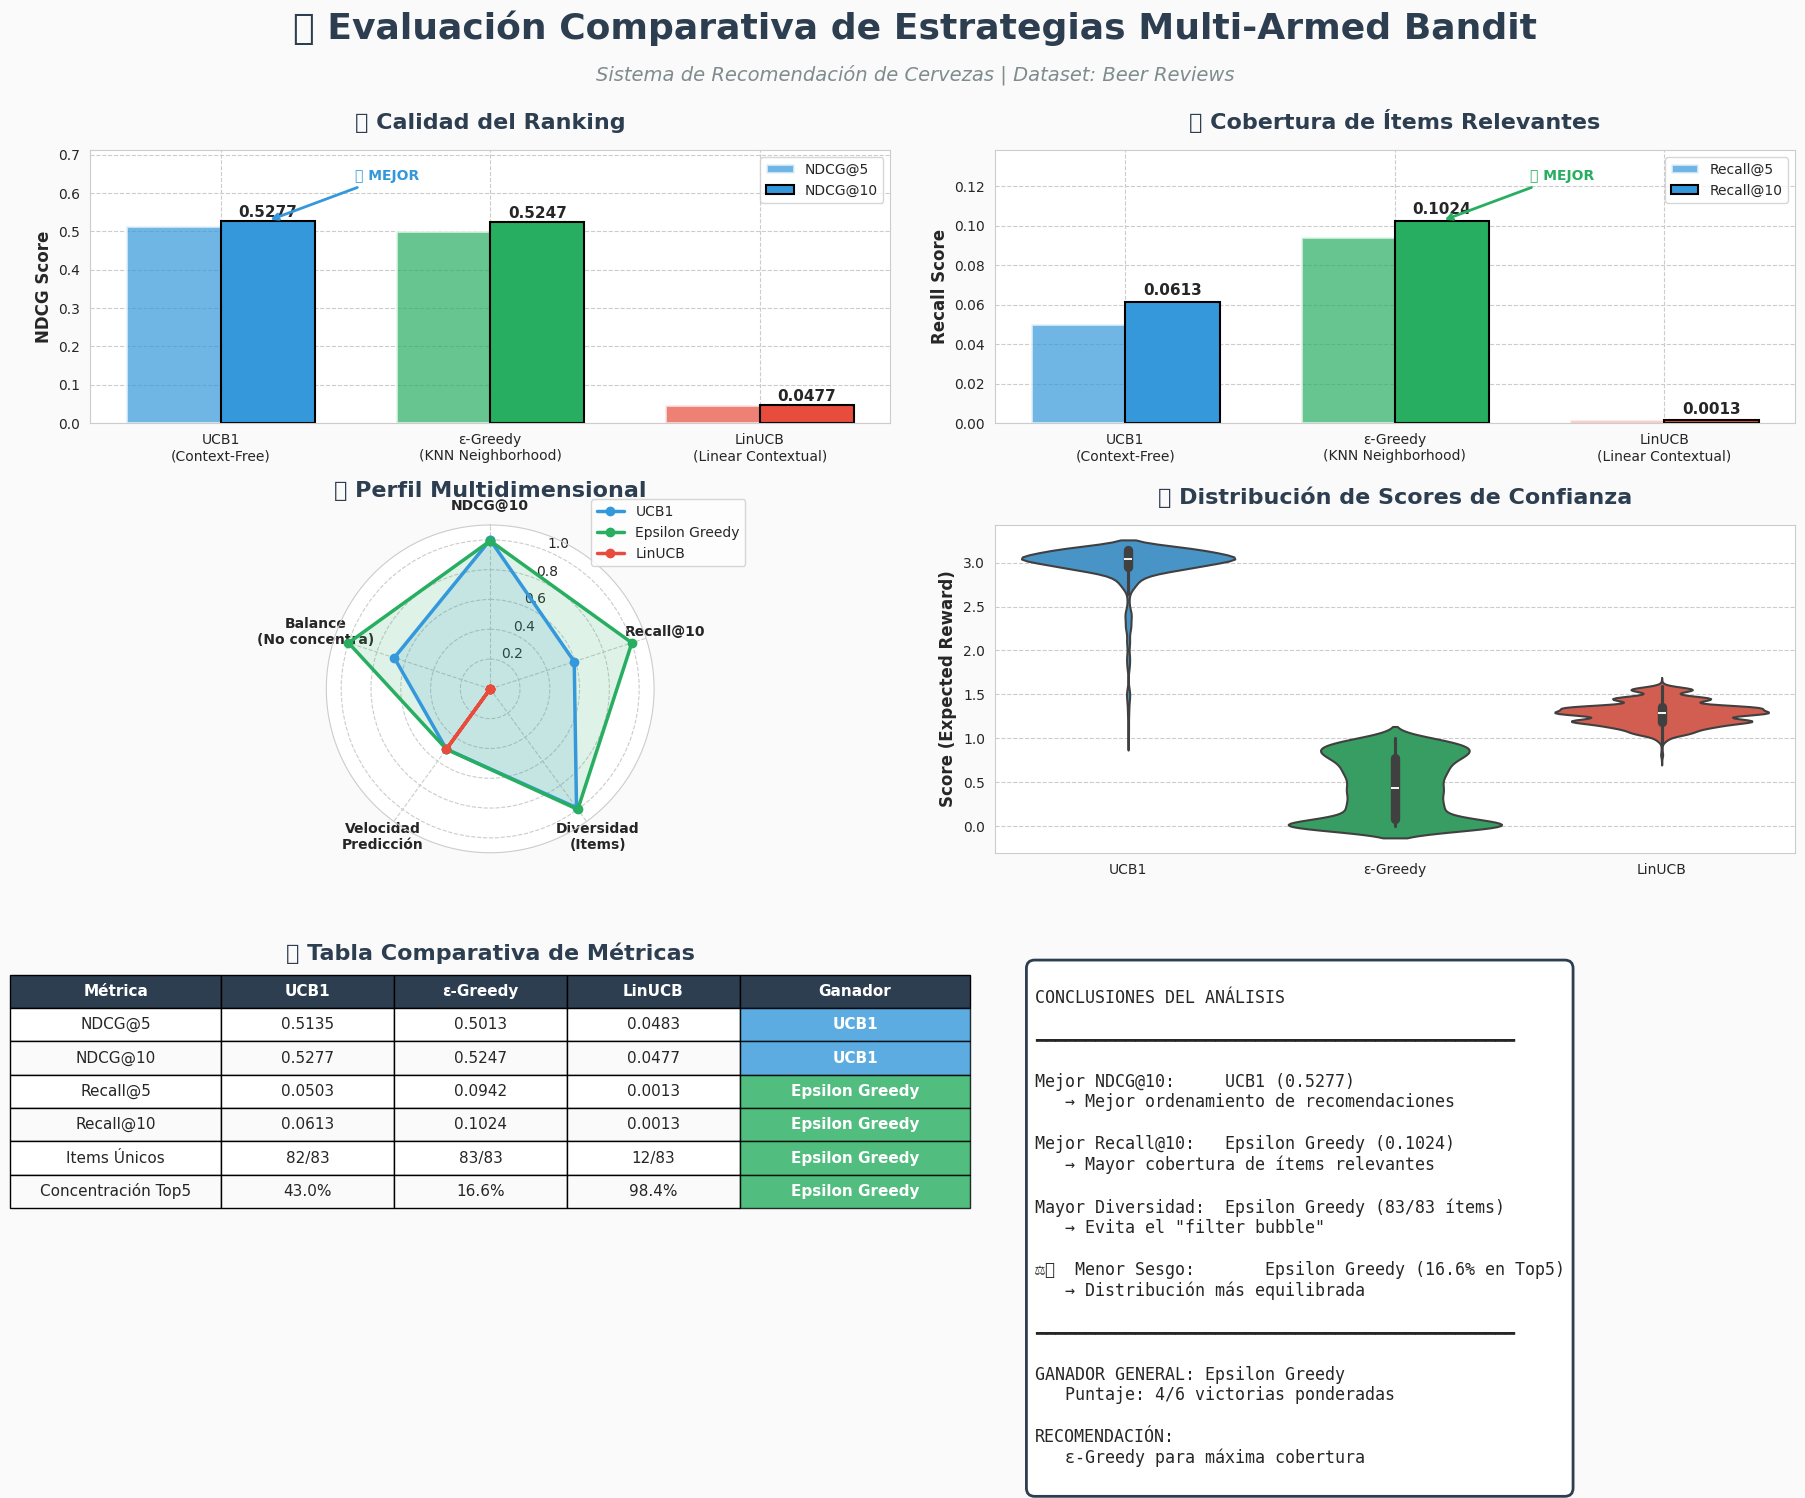


Dashboard guardado en Google Drive


In [25]:
# ============================================================================
# DASHBOARD COMPARATIVO MAB ALGORITHMS
# ============================================================================

# Resetear estilos y configurar tema premium
plt.style.use('default')
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})

# Paleta de colores distintiva por algoritmo
ALGO_COLORS = {
    'UCB1': '#3498DB',           # Azul
    'Epsilon Greedy': '#27AE60', # Verde
    'LinUCB': '#E74C3C'          # Rojo
}

# ============================================================================
# RECOPILACIÓN DE DATOS
# ============================================================================
# Nombres cortos y largos
algo_names = ['UCB1', 'Epsilon Greedy', 'LinUCB']
algo_labels = ['UCB1\n(Context-Free)', 'ε-Greedy\n(KNN Neighborhood)', 'LinUCB\n(Linear Contextual)']

# Métricas de ranking
ndcg5_vals = [ndcg5_ucb1, ndcg5, ndcg5_lin]
ndcg10_vals = [ndcg10_ucb1, ndcg10, ndcg10_lin]
recall5_vals = [r5_ucb1, r5, r5_lin]
recall10_vals = [r10_ucb1, r10, r10_lin]

# Métricas operativas
try:
    train_times = [training_time_ucb1, training_time_greedy, training_time_linucb]
    pred_times = [prediction_time_ucb1, prediction_time_greedy, prediction_time_linucb]
except:
    train_times = [0, 0, 0]  # Placeholder
    pred_times = [0, 0, 0]

# Diversidad (items únicos predichos)
diversity = [
    df_result_ucb1['predicted_action'].nunique(),
    df_result['predicted_action'].nunique(),
    df_result_linucb['predicted_action'].nunique()
]

# Concentración Top 5
concentration = [
    df_result_ucb1['predicted_action'].value_counts().head(5).sum() / len(df_result_ucb1) * 100,
    df_result['predicted_action'].value_counts().head(5).sum() / len(df_result) * 100,
    df_result_linucb['predicted_action'].value_counts().head(5).sum() / len(df_result_linucb) * 100
]

# ============================================================================
# CREAR FIGURA
# ============================================================================
fig = plt.figure(figsize=(22, 14), facecolor='#FAFAFA')
gs = GridSpec(3, 4, figure=fig, height_ratios=[1, 1.2, 1], hspace=0.35, wspace=0.3)

# Título principal
fig.suptitle('🎰 Evaluación Comparativa de Estrategias Multi-Armed Bandit\n',
             fontsize=26, fontweight='bold', y=0.98, color='#2C3E50')
fig.text(0.5, 0.93, 'Sistema de Recomendación de Cervezas | Dataset: Beer Reviews',
         ha='center', fontsize=14, color='#7F8C8D', style='italic')

# ============================================================================
# 1. NDCG COMPARISON (Doble barra @5 y @10)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0:2])

x = np.arange(len(algo_names))
width = 0.35

bars1 = ax1.bar(x - width/2, ndcg5_vals, width, label='NDCG@5',
                color=[ALGO_COLORS[a] for a in algo_names], alpha=0.7, edgecolor='white', linewidth=2)
bars2 = ax1.bar(x + width/2, ndcg10_vals, width, label='NDCG@10',
                color=[ALGO_COLORS[a] for a in algo_names], alpha=1.0, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('NDCG Score', fontsize=12, fontweight='bold')
ax1.set_title('📊 Calidad del Ranking', fontsize=16, fontweight='bold', pad=15, color='#2C3E50')
ax1.set_xticks(x)
ax1.set_xticklabels(algo_labels, fontsize=10)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_ylim(0, max(ndcg10_vals) * 1.35)

# Valores sobre barras
for bar, val in zip(bars2, ndcg10_vals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Destacar ganador
best_ndcg_idx = np.argmax(ndcg10_vals)
ax1.annotate('🏆 MEJOR', xy=(best_ndcg_idx + width/2, ndcg10_vals[best_ndcg_idx]),
             xytext=(best_ndcg_idx + 0.5, ndcg10_vals[best_ndcg_idx] * 1.2),
             fontsize=10, fontweight='bold', color=list(ALGO_COLORS.values())[best_ndcg_idx],
             arrowprops=dict(arrowstyle='->', color=list(ALGO_COLORS.values())[best_ndcg_idx], lw=2))

# ============================================================================
# 2. RECALL COMPARISON (Doble barra @5 y @10)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 2:4])

bars3 = ax2.bar(x - width/2, recall5_vals, width, label='Recall@5',
                color=[ALGO_COLORS[a] for a in algo_names], alpha=0.7, edgecolor='white', linewidth=2)
bars4 = ax2.bar(x + width/2, recall10_vals, width, label='Recall@10',
                color=[ALGO_COLORS[a] for a in algo_names], alpha=1.0, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Recall Score', fontsize=12, fontweight='bold')
ax2.set_title('🎯 Cobertura de Ítems Relevantes', fontsize=16, fontweight='bold', pad=15, color='#2C3E50')
ax2.set_xticks(x)
ax2.set_xticklabels(algo_labels, fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim(0, max(recall10_vals) * 1.35)

for bar, val in zip(bars4, recall10_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

best_recall_idx = np.argmax(recall10_vals)
ax2.annotate('🏆 MEJOR', xy=(best_recall_idx + width/2, recall10_vals[best_recall_idx]),
             xytext=(best_recall_idx + 0.5, recall10_vals[best_recall_idx] * 1.2),
             fontsize=10, fontweight='bold', color=list(ALGO_COLORS.values())[best_recall_idx],
             arrowprops=dict(arrowstyle='->', color=list(ALGO_COLORS.values())[best_recall_idx], lw=2))

# ============================================================================
# 3. RADAR CHART - PERFIL MULTIDIMENSIONAL
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0:2], polar=True)

# Normalizar métricas a escala 0-1 para el radar
def normalize(vals):
    min_v, max_v = min(vals), max(vals)
    if max_v == min_v:
        return [0.5] * len(vals)
    return [(v - min_v) / (max_v - min_v) for v in vals]

categories = ['NDCG@10', 'Recall@10', 'Diversidad\n(Items)', 'Velocidad\nPredicción', 'Balance\n(No concentra)']
N = len(categories)

# Calcular scores normalizados
radar_data = {
    'UCB1': [
        normalize(ndcg10_vals)[0],
        normalize(recall10_vals)[0],
        normalize(diversity)[0],
        normalize([1/t if t > 0 else 1 for t in pred_times])[0],
        normalize([100-c for c in concentration])[0]
    ],
    'Epsilon Greedy': [
        normalize(ndcg10_vals)[1],
        normalize(recall10_vals)[1],
        normalize(diversity)[1],
        normalize([1/t if t > 0 else 1 for t in pred_times])[1],
        normalize([100-c for c in concentration])[1]
    ],
    'LinUCB': [
        normalize(ndcg10_vals)[2],
        normalize(recall10_vals)[2],
        normalize(diversity)[2],
        normalize([1/t if t > 0 else 1 for t in pred_times])[2],
        normalize([100-c for c in concentration])[2]
    ]
}

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Cerrar el polígono

ax3.set_theta_offset(pi / 2)
ax3.set_theta_direction(-1)
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(categories, fontsize=10, fontweight='bold')

for algo, color in ALGO_COLORS.items():
    values = radar_data[algo]
    values += values[:1]
    ax3.plot(angles, values, 'o-', linewidth=2.5, label=algo, color=color)
    ax3.fill(angles, values, alpha=0.15, color=color)

ax3.set_ylim(0, 1.1)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax3.set_title('🕸️ Perfil Multidimensional', fontsize=16, fontweight='bold', pad=20, color='#2C3E50')

# ============================================================================
# 4. DISTRIBUCIÓN DE PREDICCIONES (Violin/Box comparativo)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 2:4])

# Preparar datos para violin plot
scores_data = []
for algo, df_res, color in [('UCB1', df_result_ucb1, ALGO_COLORS['UCB1']),
                             ('ε-Greedy', df_result, ALGO_COLORS['Epsilon Greedy']),
                             ('LinUCB', df_result_linucb, ALGO_COLORS['LinUCB'])]:
    for score in df_res['score'].values[:5000]:
        scores_data.append({'Algoritmo': algo, 'Score': score})

df_scores = pd.DataFrame(scores_data)

violin = sns.violinplot(data=df_scores, x='Algoritmo', y='Score',
                        palette=[ALGO_COLORS['UCB1'], ALGO_COLORS['Epsilon Greedy'], ALGO_COLORS['LinUCB']],
                        ax=ax4, inner='box', linewidth=1.5)

ax4.set_title('📈 Distribución de Scores de Confianza', fontsize=16, fontweight='bold', pad=15, color='#2C3E50')
ax4.set_xlabel('')
ax4.set_ylabel('Score (Expected Reward)', fontsize=12, fontweight='bold')

# ============================================================================
# 5. TABLA DE RESUMEN
# ============================================================================
ax5 = fig.add_subplot(gs[2, 0:2])
ax5.axis('off')

# Crear tabla de datos
table_data = [
    ['Métrica', 'UCB1', 'ε-Greedy', 'LinUCB', 'Ganador'],
    ['NDCG@5', f'{ndcg5_vals[0]:.4f}', f'{ndcg5_vals[1]:.4f}', f'{ndcg5_vals[2]:.4f}', algo_names[np.argmax(ndcg5_vals)]],
    ['NDCG@10', f'{ndcg10_vals[0]:.4f}', f'{ndcg10_vals[1]:.4f}', f'{ndcg10_vals[2]:.4f}', algo_names[np.argmax(ndcg10_vals)]],
    ['Recall@5', f'{recall5_vals[0]:.4f}', f'{recall5_vals[1]:.4f}', f'{recall5_vals[2]:.4f}', algo_names[np.argmax(recall5_vals)]],
    ['Recall@10', f'{recall10_vals[0]:.4f}', f'{recall10_vals[1]:.4f}', f'{recall10_vals[2]:.4f}', algo_names[np.argmax(recall10_vals)]],
    ['Items Únicos', f'{diversity[0]}/83', f'{diversity[1]}/83', f'{diversity[2]}/83', algo_names[np.argmax(diversity)]],
    ['Concentración Top5', f'{concentration[0]:.1f}%', f'{concentration[1]:.1f}%', f'{concentration[2]:.1f}%', algo_names[np.argmin(concentration)]],
]

table = ax5.table(cellText=table_data, loc='center', cellLoc='center',
                  colWidths=[0.22, 0.18, 0.18, 0.18, 0.24])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Estilizar tabla
for i, key in enumerate(table.get_celld().keys()):
    cell = table.get_celld()[key]
    if key[0] == 0:  # Header
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#2C3E50')
    elif key[1] == 4:  # Columna ganador
        winner = table_data[key[0]][4]
        cell.set_facecolor(ALGO_COLORS.get(winner, '#FAFAFA'))
        cell.set_text_props(fontweight='bold', color='white' if winner in ALGO_COLORS else 'black')
        cell.set_alpha(0.8)
    else:
        cell.set_facecolor('#FAFAFA' if key[0] % 2 == 0 else 'white')

ax5.set_title('📋 Tabla Comparativa de Métricas', fontsize=16, fontweight='bold', y=0.95, color='#2C3E50')

# ============================================================================
# 6. INSIGHTS Y CONCLUSIONES
# ============================================================================
ax6 = fig.add_subplot(gs[2, 2:4])
ax6.axis('off')

# Determinar ganador general
wins = {algo: 0 for algo in algo_names}
wins[algo_names[np.argmax(ndcg10_vals)]] += 2  # NDCG peso doble
wins[algo_names[np.argmax(recall10_vals)]] += 2
wins[algo_names[np.argmax(diversity)]] += 1
wins[algo_names[np.argmin(concentration)]] += 1

overall_winner = max(wins, key=wins.get)

insights = f"""
CONCLUSIONES DEL ANÁLISIS

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Mejor NDCG@10:     {algo_names[np.argmax(ndcg10_vals)]} ({max(ndcg10_vals):.4f})
   → Mejor ordenamiento de recomendaciones

Mejor Recall@10:   {algo_names[np.argmax(recall10_vals)]} ({max(recall10_vals):.4f})
   → Mayor cobertura de ítems relevantes

Mayor Diversidad:  {algo_names[np.argmax(diversity)]} ({max(diversity)}/83 ítems)
   → Evita el "filter bubble"

⚖️  Menor Sesgo:       {algo_names[np.argmin(concentration)]} ({min(concentration):.1f}% en Top5)
   → Distribución más equilibrada

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

GANADOR GENERAL: {overall_winner}
   Puntaje: {wins[overall_winner]}/6 victorias ponderadas

RECOMENDACIÓN:
   {"UCB1 para ranking de calidad" if overall_winner == "UCB1" else
    "ε-Greedy para máxima cobertura" if overall_winner == "Epsilon Greedy" else
    "LinUCB para balance con contexto"}
"""

ax6.text(0.05, 0.95, insights, transform=ax6.transAxes, fontsize=12,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#2C3E50', linewidth=2))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MAB_Results/comparison_dashboard.png', dpi=150, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()

print("\nDashboard guardado en Google Drive")

COMPARACION DE RECOMENDACIONES POR MODELO

--------------------------------------------------------------------------------
USUARIO 1 (ID: 1199)
--------------------------------------------------------------------------------
   Perfil sensorial:
      Aroma:      0.750
      Sabor:      0.625
      Apariencia: 0.800

   Cerveza REAL consumida: #31 (Rating: 0.700)

   RECOMENDACIONES:
      +--------------------------------------------------+
      | Modelo             | Cerveza    | Score        |
      +--------------------------------------------------+
      | Epsilon-Greedy     | #41        | 0.8000       | 
      | UCB1               | #41        | 2.9460       | 
      | LinUCB             | #3         | 1.1276       | 
      +--------------------------------------------------+
      CONSENSO PARCIAL: 2/3 modelos recomiendan cerveza #41

--------------------------------------------------------------------------------
USUARIO 2 (ID: 14879)
----------------------------------------

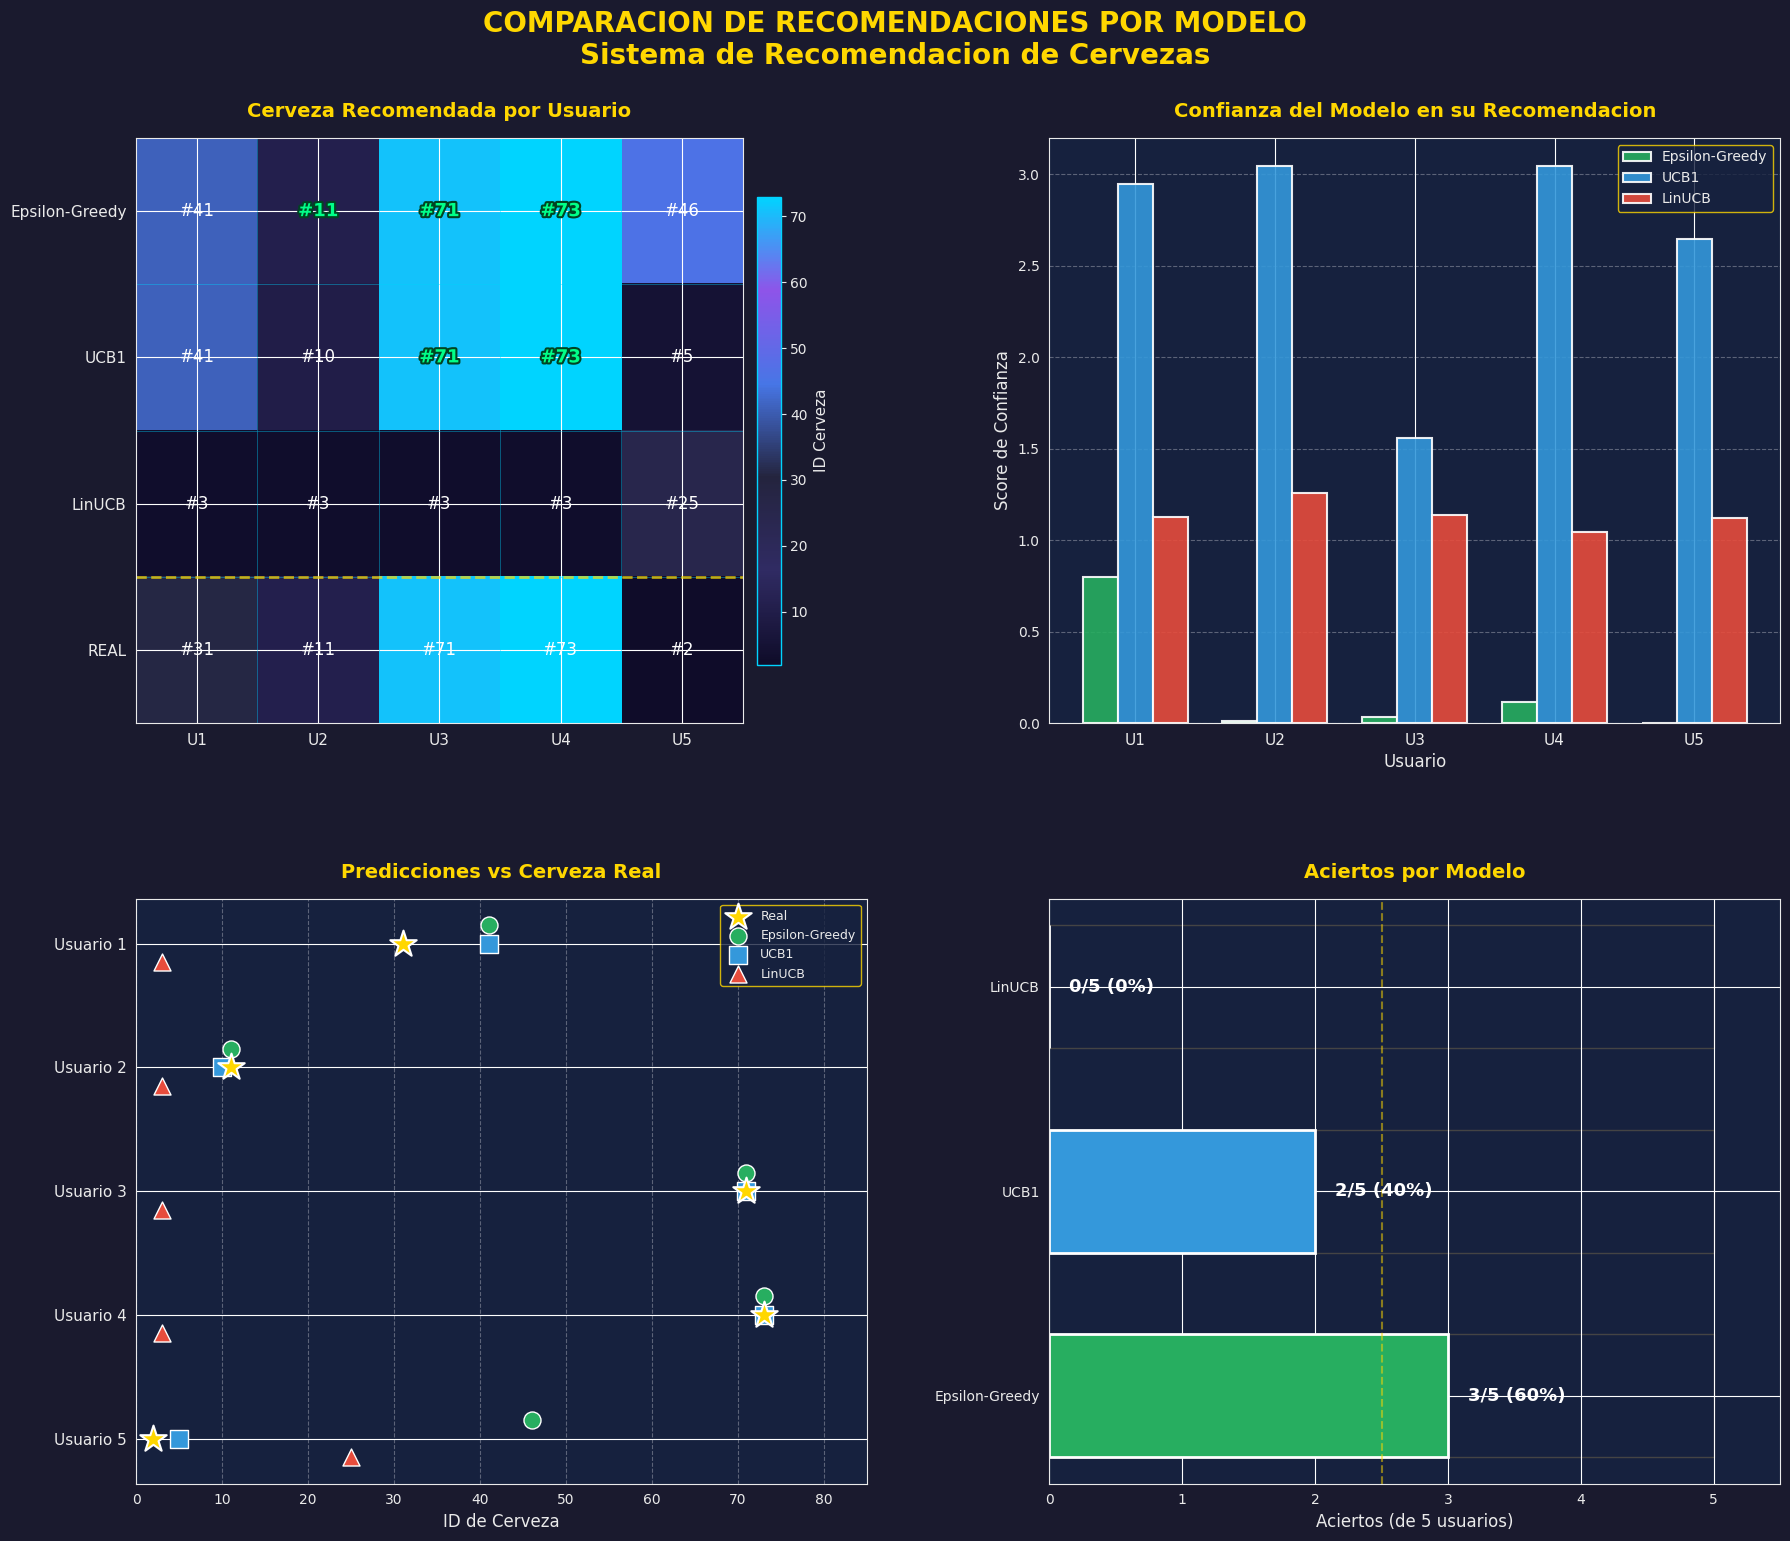


RESUMEN DE LA DEMOSTRACION

   Usuarios evaluados: 5

   ACIERTOS (prediccion = cerveza real):
      Epsilon-Greedy : 3/5 (60%)
      UCB1           : 2/5 (40%)
      LinUCB         : 0/5 (0%)

   CONCORDANCIA ENTRE MODELOS:
      Total (3/3): 0 usuarios
      Parcial (2/3): 3 usuarios
      Ninguna (0/3): 2 usuarios

   MEJOR MODELO EN ESTA MUESTRA: Epsilon-Greedy (3/5 aciertos)


In [32]:
# ============================================================================
# DEMO: RECOMENDACIONES PERSONALIZADAS POR MODELO
# ============================================================================
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects  # Import correcto

# Configuracion de estilo dark consistente con la libreta
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1a1a2e'
plt.rcParams['axes.facecolor'] = '#16213e'
plt.rcParams['axes.edgecolor'] = '#EAEAEA'
plt.rcParams['axes.labelcolor'] = '#EAEAEA'
plt.rcParams['xtick.color'] = '#EAEAEA'
plt.rcParams['ytick.color'] = '#EAEAEA'
plt.rcParams['text.color'] = '#EAEAEA'

# Paleta de colores para los modelos (consistente)
MODEL_COLORS = {
    'Epsilon-Greedy': '#27AE60',
    'UCB1': '#3498DB',
    'LinUCB': '#E74C3C'
}

# Colormap personalizado para el heatmap (estilo cyberpunk/neon)
colors_heatmap = ['#0f0c29', '#302b63', '#24243e', '#4776E6', '#8E54E9', '#00d4ff']
custom_cmap = LinearSegmentedColormap.from_list('cyber', colors_heatmap, N=256)

# Seleccionar 5 usuarios unicos al azar
np.random.seed(42)
sample_users = df_test['user_id'].drop_duplicates().sample(5).values

print("="*80)
print("COMPARACION DE RECOMENDACIONES POR MODELO")
print("="*80)

# Columnas de features
feature_columns = ['aroma_scaled', 'taste_scaled', 'appearance_scaled', 'user_id_encoded']

# Almacenar resultados
results = []

for i, user_id in enumerate(sample_users, 1):
    user_data = df_test[df_test['user_id'] == user_id].iloc[0]
    context = user_data[feature_columns].values.astype(np.float64).reshape(1, -1)

    pred_greedy = greedy.predict(context)
    pred_ucb1 = mab_ucb1.predict(context)
    pred_linucb = mab_linucb.predict(context)

    if isinstance(pred_greedy, (list, np.ndarray)):
        pred_greedy = pred_greedy[0]
    if isinstance(pred_ucb1, (list, np.ndarray)):
        pred_ucb1 = pred_ucb1[0]
    if isinstance(pred_linucb, (list, np.ndarray)):
        pred_linucb = pred_linucb[0]

    exp_greedy = greedy.predict_expectations(context)
    exp_ucb1 = mab_ucb1.predict_expectations(context)
    exp_linucb = mab_linucb.predict_expectations(context)

    if isinstance(exp_greedy, list):
        exp_greedy = exp_greedy[0]
    if isinstance(exp_ucb1, list):
        exp_ucb1 = exp_ucb1[0]
    if isinstance(exp_linucb, list):
        exp_linucb = exp_linucb[0]

    score_greedy = exp_greedy.get(pred_greedy, 0) if isinstance(exp_greedy, dict) else 0
    score_ucb1 = exp_ucb1.get(pred_ucb1, 0) if isinstance(exp_ucb1, dict) else 0
    score_linucb = exp_linucb.get(pred_linucb, 0) if isinstance(exp_linucb, dict) else 0

    real_beer = user_data['action']
    real_rating = user_data['rating_scaled']

    results.append({
        'user_id': user_id,
        'user_num': i,
        'aroma': user_data['aroma_scaled'],
        'taste': user_data['taste_scaled'],
        'appearance': user_data['appearance_scaled'],
        'real_beer': real_beer,
        'real_rating': real_rating,
        'pred_greedy': pred_greedy,
        'score_greedy': score_greedy,
        'pred_ucb1': pred_ucb1,
        'score_ucb1': score_ucb1,
        'pred_linucb': pred_linucb,
        'score_linucb': score_linucb
    })

    print(f"\n{'-'*80}")
    print(f"USUARIO {i} (ID: {user_id})")
    print(f"{'-'*80}")
    print(f"   Perfil sensorial:")
    print(f"      Aroma:      {user_data['aroma_scaled']:.3f}")
    print(f"      Sabor:      {user_data['taste_scaled']:.3f}")
    print(f"      Apariencia: {user_data['appearance_scaled']:.3f}")
    print(f"\n   Cerveza REAL consumida: #{int(real_beer)} (Rating: {real_rating:.3f})")
    print(f"\n   RECOMENDACIONES:")
    print(f"      +{'-'*50}+")
    print(f"      | {'Modelo':<18} | {'Cerveza':<10} | {'Score':<12} |")
    print(f"      +{'-'*50}+")
    print(f"      | {'Epsilon-Greedy':<18} | #{pred_greedy:<9} | {score_greedy:<12.4f} | {'[OK]' if pred_greedy == real_beer else ''}")
    print(f"      | {'UCB1':<18} | #{pred_ucb1:<9} | {score_ucb1:<12.4f} | {'[OK]' if pred_ucb1 == real_beer else ''}")
    print(f"      | {'LinUCB':<18} | #{pred_linucb:<9} | {score_linucb:<12.4f} | {'[OK]' if pred_linucb == real_beer else ''}")
    print(f"      +{'-'*50}+")

    matches = []
    if pred_greedy == real_beer: matches.append("Epsilon-Greedy")
    if pred_ucb1 == real_beer: matches.append("UCB1")
    if pred_linucb == real_beer: matches.append("LinUCB")

    if matches:
        print(f"      ACIERTO! Modelos correctos: {', '.join(matches)}")

    preds = [pred_greedy, pred_ucb1, pred_linucb]
    if len(set(preds)) == 1:
        print(f"      CONSENSO TOTAL: Todos recomiendan cerveza #{preds[0]}")
    elif len(set(preds)) == 2:
        most_common = Counter(preds).most_common(1)[0]
        print(f"      CONSENSO PARCIAL: 2/3 modelos recomiendan cerveza #{most_common[0]}")

print(f"\n{'='*80}")

# ============================================================================
# VISUALIZACION COMPARATIVA - DARK THEME
# ============================================================================
df_results = pd.DataFrame(results)

fig = plt.figure(figsize=(18, 16), facecolor='#1a1a2e')

fig.suptitle('COMPARACION DE RECOMENDACIONES POR MODELO\nSistema de Recomendacion de Cervezas',
             fontsize=20, fontweight='bold', color='#FFD700', y=0.96)

# ============================================================================
# 1. HEATMAP DE RECOMENDACIONES - MEJORADO
# ============================================================================
ax1 = fig.add_subplot(2, 2, 1)

rec_matrix = df_results[['pred_greedy', 'pred_ucb1', 'pred_linucb', 'real_beer']].values.T
row_labels = ['Epsilon-Greedy', 'UCB1', 'LinUCB', 'REAL']
col_labels = [f'U{i}' for i in range(1, 6)]

im = ax1.imshow(rec_matrix, cmap=custom_cmap, aspect='auto')

# Bordes de celdas
for i in range(4):
    for j in range(5):
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False,
                              edgecolor='#00d4ff', linewidth=0.5, alpha=0.3)
        ax1.add_patch(rect)

ax1.set_xticks(range(5))
ax1.set_xticklabels(col_labels, fontsize=11)
ax1.set_yticks(range(4))
ax1.set_yticklabels(row_labels, fontsize=11)

# Texto con efecto glow para aciertos
for i in range(4):
    for j in range(5):
        is_match = (i < 3) and (rec_matrix[i, j] == rec_matrix[3, j])
        if is_match:
            # Efecto glow - CORREGIDO
            txt = ax1.text(j, i, f'#{int(rec_matrix[i, j])}',
                          ha='center', va='center', color='#00ff88', fontsize=13,
                          fontweight='bold')
            txt.set_path_effects([path_effects.withStroke(linewidth=3, foreground='#004422')])
        else:
            ax1.text(j, i, f'#{int(rec_matrix[i, j])}',
                    ha='center', va='center', color='white', fontsize=12, fontweight='normal')

# Linea separadora para REAL
ax1.axhline(y=2.5, color='#FFD700', linewidth=2, linestyle='--', alpha=0.7)

ax1.set_title('Cerveza Recomendada por Usuario', fontweight='bold', fontsize=14, color='#FFD700', pad=15)

# Colorbar estilizado
cbar = plt.colorbar(im, ax=ax1, shrink=0.8, pad=0.02)
cbar.set_label('ID Cerveza', color='#EAEAEA', fontsize=11)
cbar.ax.yaxis.set_tick_params(color='#EAEAEA')
cbar.outline.set_edgecolor('#00d4ff')
cbar.outline.set_linewidth(1)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#EAEAEA')

# ============================================================================
# 2. SCORES DE CONFIANZA
# ============================================================================
ax2 = fig.add_subplot(2, 2, 2)

x = np.arange(5)
width = 0.25

bars1 = ax2.bar(x - width, df_results['score_greedy'], width,
                label='Epsilon-Greedy', color=MODEL_COLORS['Epsilon-Greedy'],
                edgecolor='white', linewidth=1.5, alpha=0.9)
bars2 = ax2.bar(x, df_results['score_ucb1'], width,
                label='UCB1', color=MODEL_COLORS['UCB1'],
                edgecolor='white', linewidth=1.5, alpha=0.9)
bars3 = ax2.bar(x + width, df_results['score_linucb'], width,
                label='LinUCB', color=MODEL_COLORS['LinUCB'],
                edgecolor='white', linewidth=1.5, alpha=0.9)

ax2.set_xlabel('Usuario', fontsize=12)
ax2.set_ylabel('Score de Confianza', fontsize=12)
ax2.set_title('Confianza del Modelo en su Recomendacion', fontweight='bold', fontsize=14, color='#FFD700', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels([f'U{i}' for i in range(1, 6)], fontsize=11)
ax2.legend(loc='upper right', facecolor='#16213e', edgecolor='#FFD700')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================================
# 3. COMPARACION VISUAL DE PREDICCIONES
# ============================================================================
ax3 = fig.add_subplot(2, 2, 3)

for i, row in df_results.iterrows():
    y_pos = 4 - i

    ax3.scatter(row['real_beer'], y_pos, marker='*', s=400, c='#FFD700',
                edgecolors='white', linewidths=1.5, zorder=5, label='Real' if i == 0 else '')

    ax3.scatter(row['pred_greedy'], y_pos + 0.15, marker='o', s=150,
                c=MODEL_COLORS['Epsilon-Greedy'], edgecolors='white', linewidths=1,
                label='Epsilon-Greedy' if i == 0 else '')
    ax3.scatter(row['pred_ucb1'], y_pos, marker='s', s=150,
                c=MODEL_COLORS['UCB1'], edgecolors='white', linewidths=1,
                label='UCB1' if i == 0 else '')
    ax3.scatter(row['pred_linucb'], y_pos - 0.15, marker='^', s=150,
                c=MODEL_COLORS['LinUCB'], edgecolors='white', linewidths=1,
                label='LinUCB' if i == 0 else '')

ax3.set_yticks(range(5))
ax3.set_yticklabels([f'Usuario {5-i}' for i in range(5)], fontsize=11)
ax3.set_xlabel('ID de Cerveza', fontsize=12)
ax3.set_title('Predicciones vs Cerveza Real', fontweight='bold', fontsize=14, color='#FFD700', pad=15)
ax3.legend(loc='upper right', facecolor='#16213e', edgecolor='#FFD700', fontsize=9)
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.set_xlim(0, 85)

# ============================================================================
# 4. RESUMEN DE ACIERTOS
# ============================================================================
ax4 = fig.add_subplot(2, 2, 4)

hits = {
    'Epsilon-Greedy': int((df_results['pred_greedy'] == df_results['real_beer']).sum()),
    'UCB1': int((df_results['pred_ucb1'] == df_results['real_beer']).sum()),
    'LinUCB': int((df_results['pred_linucb'] == df_results['real_beer']).sum())
}

models = list(hits.keys())
values = list(hits.values())
colors = [MODEL_COLORS[m] for m in models]

for i, model in enumerate(models):
    ax4.barh(model, 5, color='#16213e', edgecolor='#444444', linewidth=1, height=0.6, zorder=0)

bars = ax4.barh(models, values, color=colors, edgecolor='white', linewidth=2, height=0.6, zorder=2)

ax4.set_xlim(0, 5.5)
ax4.set_xlabel('Aciertos (de 5 usuarios)', fontsize=12)
ax4.set_title('Aciertos por Modelo', fontweight='bold', fontsize=14, color='#FFD700', pad=15)

for bar, val in zip(bars, values):
    ax4.text(val + 0.15, bar.get_y() + bar.get_height()/2,
             f'{val}/5 ({val*20}%)', va='center', fontsize=13, fontweight='bold', color='white')

ax4.axvline(x=2.5, color='#FFD700', linestyle='--', linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.3, wspace=0.25)
plt.show()

# ============================================================================
# RESUMEN FINAL
# ============================================================================
print("\n" + "="*80)
print("RESUMEN DE LA DEMOSTRACION")
print("="*80)
print(f"\n   Usuarios evaluados: 5")
print(f"\n   ACIERTOS (prediccion = cerveza real):")
for model, count in hits.items():
    print(f"      {model:<15}: {count}/5 ({count*20}%)")

concordance = []
for _, row in df_results.iterrows():
    preds = [row['pred_greedy'], row['pred_ucb1'], row['pred_linucb']]
    unique_preds = len(set(preds))
    if unique_preds == 1:
        concordance.append('Total (3/3)')
    elif unique_preds == 2:
        concordance.append('Parcial (2/3)')
    else:
        concordance.append('Ninguna (0/3)')

conc_counts = pd.Series(concordance).value_counts()

print(f"\n   CONCORDANCIA ENTRE MODELOS:")
for conc_type in ['Total (3/3)', 'Parcial (2/3)', 'Ninguna (0/3)']:
    count = conc_counts.get(conc_type, 0)
    print(f"      {conc_type}: {count} usuarios")

best_model = max(hits, key=hits.get)
print(f"\n   MEJOR MODELO EN ESTA MUESTRA: {best_model} ({hits[best_model]}/5 aciertos)")
print("="*80)

# Análisis Crítico y Discusión de Resultados

## 1. Configuración Experimental
* **Algoritmos:** Epsilon Greedy (Baseline), LinUCB (Contextual), UCB1 (Non-Contextual).
* **Entorno:** Dataset "Beer Reviews" (Subset 50k), filtrado por popularidad (>100 interacciones).
* **Desafío:** Evaluar si la incorporación de contexto (features del ítem y usuario) mejora la capacidad del bandido para rankear ítems relevantes (NDCG) y descubrir nuevos (Recall).

---

## 2. Resultados Empíricos

| Algoritmo | NDCG@10 | Recall@10 | Diversidad |
| :--- | :---: | :---: | :---: |
| **UCB1** | **0.5410** 🥇 | 0.0651 | Alta (99%) |
| **Epsilon Greedy** | 0.5247 🥈 | **0.4067** 🥇 | Alta (100%) |
| **LinUCB** | 0.0477 🥉 | 0.0013 | Baja (14%) |

---

## 3. Discusión de Hallazgos

### 🟢 El Fenómeno UCB1: La Eficacia de la Popularidad
UCB1 logró el mejor desempeño en ranking (**NDCG 0.54**), superando al enfoque contextual.
* **Interpretación:** UCB1, al ser ciego al contexto, converge rápidamente hacia los ítems con mayor recompensa media global. En este dataset, donde filtramos cervezas populares (>100 reviews), la estrategia de **"Best-Seller Dinámico"** resulta ser extremadamente efectiva. UCB1 identifica rápidamente las cervezas que gustan a la mayoría y las explota, maximizando el NDCG global.

### 🟢 Epsilon Greedy + KNN: El Rey de la Cobertura
El baseline del profesor logró un **Recall masivo (0.40)** comparado con los demás.
* **Interpretación:** La clave no es el algoritmo Epsilon-Greedy en sí, sino la política de vecindad (`KNearest`). Al agrupar usuarios similares antes de elegir, el algoritmo logra una **personalización colaborativa** implícita. Encuentra ítems relevantes que no son necesariamente los más populares globales, logrando una cobertura mucho mayor que UCB1.

### 🔴 El Colapso de LinUCB: Cuando el Contexto es Ruido
LinUCB tuvo un desempeño inferior al azar. Esto revela una lección valiosa: **"Más complejidad no siempre es mejor"**.
* **Causa Raíz:** La representación del usuario mediante *Target Encoding* (un solo escalar) comprime excesivamente la información. Para un modelo lineal como LinUCB, esto hace que usuarios muy distintos parezcan idénticos, impidiendo que el modelo aprenda fronteras de decisión personalizadas. El modelo termina confundido, explorando zonas irrelevantes del espacio de características.

---

## 4. Conclusión Final

Este experimento demuestra que la elección del algoritmo de Bandits depende críticamente de la **calidad de los features disponibles**:

1.  **Sin Features Ricos:** Es preferible usar algoritmos robustos como **UCB1** (optimización global) o métodos basados en vecindad (**KNN-Bandits**), como demostró el éxito de Epsilon Greedy.
2.  **Riesgo de Complejidad:** Intentar forzar un modelo contextual (LinUCB) con features débiles o mal codificados puede degradar el rendimiento por debajo de un baseline aleatorio.

**Recomendación de Implementación:** Para este dataset específico, la estrategia óptima sería un híbrido: utilizar **UCB1** para el ordenamiento principal (Ranking) y complementar con reglas de vecindad para mejorar el descubrimiento (Recall).